### GPU 사용 설정

In [3]:
from tensorflow.python.client import device_lib
import tensorflow as tf

print(device_lib.list_local_devices())
tf.config.list_physical_devices('GPU')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17215458311383449239
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5732564992
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11272837690942580336
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# <정량평가>

### 데이터 불러오기

In [5]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import Dense, LSTM, Conv1D, AveragePooling1D, MaxPooling1D, Dropout, LeakyReLU
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, ConvLSTM2D, Input, Reshape
from tensorflow.keras import Model, Sequential, optimizers, regularizers

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import shap

import pandas as pd
import numpy as np
import os

In [6]:
files = os.listdir('./train_input/')
path = './train_input/'

train_df_list = []

for file in files:
    if 'CASE' in file:
        df = pd.read_csv(path + file)
        train_df_list.append(df)

df = pd.concat(train_df_list).reset_index(drop=True)
df

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,00:00,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
1,0,01:00,25.680357,81.264286,528.696429,1.409003,126.0,126.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
2,0,02:00,25.273333,81.471666,532.833333,1.406913,0.0,126.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
3,0,03:00,25.355000,81.398334,545.566667,1.406689,126.0,252.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
4,0,04:00,25.391667,81.483333,558.583333,1.411070,0.0,252.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,27,19:00,26.030000,58.736667,448.500000,1.195415,0.0,2543.12,12.3764,146722.222,0.0,22253.7504,0.0,10462.6535,12.3764,179438.6259
18812,27,20:00,27.341666,58.373334,449.183333,1.190780,126.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259
18813,27,21:00,27.785000,58.711667,441.933333,1.185593,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259
18814,27,22:00,28.480000,58.121667,437.600000,1.179664,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259


### 데이터 전처리

In [7]:
# 시간이 다르게 표기된 부분 통일

pd.set_option('display.max_rows', 10)
df['obs_time'] = df['obs_time'].apply(lambda x: '02:00:00.' if x=='01:59:59.' else x)
df['obs_time'] = df['obs_time'].apply(lambda x: '03:00:00.' if x=='02:59:59.' else x)
df['obs_time'] = df['obs_time'].apply(lambda x: '04:00:00.' if x=='03:59:59.' else x)
df['obs_time'] = df['obs_time'].apply(lambda x: '05:00:00.' if x=='04:59:59.' else x)
df['obs_time'] = df['obs_time'].apply(lambda x: '06:00:00.' if x=='05:59:59.' else x)
df['obs_time'] = df['obs_time'].apply(lambda x: '07:00:00.' if x=='06:59:59.' else x)
df['obs_time'] = df['obs_time'].apply(lambda x: '08:00:00.' if x=='07:59:59.' else x)
df['obs_time'] = df['obs_time'].apply(lambda x: '09:00:00.' if x=='08:59:59.' else x)
df['obs_time'] = df['obs_time'].apply(lambda x: '10:00:00.' if x=='09:59:59.' else x)
df['obs_time'] = df['obs_time'].apply(lambda x: '11:00:00.' if x=='10:59:59.' else x)
df['obs_time'] = df['obs_time'].apply(lambda x: '12:00:00.' if x=='11:59:59.' else x)
df['obs_time'] = df['obs_time'].apply(lambda x: '13:00:00.' if x=='12:59:59.' else x)
df['obs_time'] = df['obs_time'].apply(lambda x: '14:00:00.' if x=='13:59:59.' else x)
df['obs_time'] = df['obs_time'].apply(lambda x: '15:00:00.' if x=='14:59:59.' else x)
df['obs_time'] = df['obs_time'].apply(lambda x: '16:00:00.' if x=='15:59:59.' else x)
df['obs_time'] = df['obs_time'].apply(lambda x: '17:00:00.' if x=='16:59:59.' else x)
df['obs_time'] = df['obs_time'].apply(lambda x: '18:00:00.' if x=='17:59:59.' else x)
df['obs_time'] = df['obs_time'].apply(lambda x: '19:00:00.' if x=='18:59:59.' else x)
df['obs_time'] = df['obs_time'].apply(lambda x: '20:00:00.' if x=='19:59:59.' else x)
df['obs_time'] = df['obs_time'].apply(lambda x: '21:00:00.' if x=='20:59:59.' else x)
df['obs_time'] = df['obs_time'].apply(lambda x: '22:00:00.' if x=='21:59:59.' else x)
df['obs_time'] = df['obs_time'].apply(lambda x: '23:00:00.' if x=='22:59:59.' else x)

df

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,00:00,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
1,0,01:00,25.680357,81.264286,528.696429,1.409003,126.0,126.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
2,0,02:00,25.273333,81.471666,532.833333,1.406913,0.0,126.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
3,0,03:00,25.355000,81.398334,545.566667,1.406689,126.0,252.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
4,0,04:00,25.391667,81.483333,558.583333,1.411070,0.0,252.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,27,19:00,26.030000,58.736667,448.500000,1.195415,0.0,2543.12,12.3764,146722.222,0.0,22253.7504,0.0,10462.6535,12.3764,179438.6259
18812,27,20:00,27.341666,58.373334,449.183333,1.190780,126.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259
18813,27,21:00,27.785000,58.711667,441.933333,1.185593,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259
18814,27,22:00,28.480000,58.121667,437.600000,1.179664,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259


In [8]:
# 음의 값 -> 양수로..
# 독립 변수들의 단위가 크게 다르기 때문에 정규화 진행

def prepro(df):
    df.obs_time = df.obs_time.apply(lambda x: x[:2]).astype('int')
    df = df.abs()
    
    mm_sc = MinMaxScaler()
    mm_array = mm_sc.fit_transform(df)
    mm_df = pd.DataFrame(mm_array, columns=df.columns.tolist())
    
    return mm_df

df1 = prepro(df)

In [9]:
## 시간당 관측값과 누적값은 서로 파생변수가 될 수 있는 관계로
## 모두 사용할 경우 독립변수들 간의 상관관계가 높아 복잡도만 높아질 뿐, 학습에 악영향을 끼칠 것으로 판단.
## 두 종류의 feature들 중에 하나만 사용..

## 일간누적
# df2 = df1.iloc[:,[0,2,3,4,5,7,9,11,13,15]]

## 시간당
df2 = df1.iloc[:,[0,2,3,4,5,6,8,10,12,14]]

## 전부 사용
# df2 = df1.drop(['obs_time'], axis=1)

df2

,DAT,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,시간당총광량
0,0.0,0.593293,0.876647,0.287477,0.257663,0.000000,0.000000,0.0,0.0,0.000000
1,0.0,0.602213,0.870533,0.283053,0.257949,0.040075,0.000000,0.0,0.0,0.000000
2,0.0,0.592668,0.872755,0.285553,0.257567,0.000000,0.000000,0.0,0.0,0.000000
3,0.0,0.594583,0.871969,0.293250,0.257526,0.040075,0.000000,0.0,0.0,0.000000
4,0.0,0.595443,0.872880,0.301117,0.258328,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
18811,1.0,0.610412,0.629209,0.234579,0.218847,0.000000,0.000089,0.0,0.0,0.000075
18812,1.0,0.641171,0.625317,0.234992,0.217999,0.040075,0.000000,0.0,0.0,0.000000
18813,1.0,0.651567,0.628941,0.230610,0.217049,0.000000,0.000000,0.0,0.0,0.000000
18814,1.0,0.667865,0.622621,0.227991,0.215964,0.000000,0.000000,0.0,0.0,0.000000


In [10]:
# target값의 shape과 맞추기 위한 feature data set 정의..
# feature data는 시간별 data인 반면에 target data는 일별 data이기 때문에 feature data를 24시간 간격으로 자름
def slice_24(df):
    array_list = []
    
    for i in range(int(len(df)/24)):
        one_day_array = df.iloc[i*24:(i+1)*24,:].to_numpy()
        array_list.append(one_day_array)
    
    return array_list


sliced_array_list = slice_24(df2)

input_data = np.array(sliced_array_list)
input_data = input_data.reshape(784,24,10,1)
input_data.shape

# reshape 끝에 1을 찍어주는 이유는 Conv2D의 input shape과 맞춰주기 위함

(784, 24, 10, 1)

In [11]:
# 학습 target data set 불러오기..
path = './train_target/'
files = os.listdir(path)

target_df_list = []

for file in files:
    if 'csv' in file:
        df2 = pd.read_csv(path+file)
        target_df_list.append(df2)

# target dataㅂ 정의
target_df = pd.concat(target_df_list)['predicted_weight_g'].reset_index(drop=True)
print(target_df)

targets = target_df.values
targets.shape

0       0.167719
1       0.181787
2       0.265921
3       0.423650
4       0.475272
         ...    
779    64.875499
780    74.002614
781    76.342275
782    82.621245
783    86.591508
Name: predicted_weight_g, Length: 784, dtype: float64


(784,)

In [12]:
# KFold없이 진행시 train, test split

# ## train, validation split
# # 672> 24째 CASE까지
# X_train = input_data[:672]
# X_val = input_data[672:]
# y_train = targets[:672]
# y_val = targets[672:]

                
# print(X_train.shape)
# print(y_train.shape)


# train_dataset = [X_train, y_train]
# val_dataset = [X_val, y_val]

### 모델 정의 및 학습

#### 참고
Total params = recurrent_weights + input_weights + biases

= (num_units*num_units)+(num_features*num_units) + (1*num_units)

= (num_features + num_units)* num_units + num_units

In [13]:
# rmse 함수 정의

def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [14]:
## 모델 정의 - 2D CNN + LSTM MODEL
def CnnLstmModel(X_train, y_train, X_val, y_val, BATCH_SIZE, EPOCHS, hidden_units, opti, NORM, early_stopping, checkpoint):
    model = Sequential()
    model.add(Conv2D(hidden_units,
                     kernel_size=3,
                     input_shape=(X_train.shape[1:]),
                     kernel_regularizer=NORM,
                     activation='elu'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Reshape((7, 2*360)))
    model.add(Dropout(0.3))
    model.add(LSTM(180,
                   activation='tanh', # elu 사용시 기울기 폭주함
                   kernel_regularizer=NORM,
                   return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    

    
    model.summary()
    model.compile(optimizer=opti, loss=rmse)
    model.fit(X_train, 
              y_train, 
              validation_data=[X_val, y_val], 
              batch_size=BATCH_SIZE, 
              epochs=EPOCHS, 
              verbose=1,
              callbacks=[early_stopping, checkpoint])

    return model

In [ ]:
# kfold 학습 함수 정의
def kFoldModelFit(input_data, targets, BATCH_SIZE, EPOCHS, hidden_units, NORM):
    kfold = KFold(n_splits=7, shuffle=False)

    # 학습 후 그래프 그리기 위한 리스트
    X_val_list = []
    y_val_list = []

    # KFold Cross Validation으로 모델 학습
    for i, (train_idx, val_idx) in enumerate(kfold.split(input_data, targets)):
        print('\n', '-'*10, i, '-'*10, '\n')
        
        X_train, X_val = input_data[train_idx], input_data[val_idx]
        y_train, y_val = targets[train_idx], targets[val_idx]

        X_val_list.append(input_data[val_idx])
        y_val_list.append(targets[val_idx])

        opti = optimizers.Adam(learning_rate=0.0003)

        early_stopping = EarlyStopping(monitor='val_loss', patience=500, mode='min')

        save_path = './model_save/'+f'{i+1}_fold_'+'{epoch:03d}-{val_loss:.4f}.hdf5'
        checkpoint = ModelCheckpoint(filepath=save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


        model = CnnLstmModel(X_train, y_train, X_val, y_val, BATCH_SIZE, EPOCHS, hidden_units, opti, NORM, early_stopping, checkpoint)

        return model

In [66]:
# 2차원의 CNN + LSTM 모델 정의
# 기본적으로 시계열 데이터이므로 LSTM 모델이 가장 적합하다고 판단.
# 어느 시간대에 어느 피처값이 중요하게 작용하는지 그 특징을 찾아내기 위해 CNN을 활용함. (특징 추출)

hidden_units = 360 # (24*10)의 1.5배로 설정
BATCH_SIZE = 8
EPOCHS = 700
NORM = regularizers.l2(0.01)

# leaky_relu = LeakyReLU(0.2)

model = kFoldModelFit(input_data, targets, BATCH_SIZE, EPOCHS, hidden_units, NORM)


 ---------- 0 ---------- 

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 22, 8, 360)        3600      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 2, 360)        0         
 2D)                                                             
                                                                 
 reshape_7 (Reshape)         (None, 7, 720)            0         
                                                                 
 dropout_14 (Dropout)        (None, 7, 720)            0         
                                                                 
 lstm_7 (LSTM)               (None, 180)               648720    
                                                                 
 dropout_15 (Dropout)        (None, 180)               0         
                          

Epoch 29/700
77/84 [==========================>...] - ETA: 0s - loss: 19.2616
Epoch 29: val_loss did not improve from 13.61500
84/84 [==============================] - 0s 3ms/step - loss: 19.6201 - val_loss: 15.0963
Epoch 30/700
75/84 [=========================>....] - ETA: 0s - loss: 20.1135
Epoch 30: val_loss improved from 13.61500 to 13.35592, saving model to ./model_save\1_fold_030-13.3559.hdf5
84/84 [==============================] - 0s 3ms/step - loss: 19.8478 - val_loss: 13.3559
Epoch 31/700
63/84 [=====================>........] - ETA: 0s - loss: 18.5922
Epoch 31: val_loss did not improve from 13.35592
84/84 [==============================] - 0s 3ms/step - loss: 19.2673 - val_loss: 13.6626
Epoch 32/700
63/84 [=====================>........] - ETA: 0s - loss: 18.2117
Epoch 32: val_loss did not improve from 13.35592
84/84 [==============================] - 0s 3ms/step - loss: 18.2751 - val_loss: 13.8894
Epoch 33/700
73/84 [=========================>....] - ETA: 0s - loss: 18.0782

84/84 [==============================] - 0s 3ms/step - loss: 12.8128 - val_loss: 14.0347
Epoch 66/700
67/84 [======================>.......] - ETA: 0s - loss: 12.3002
Epoch 66: val_loss improved from 12.06320 to 11.56336, saving model to ./model_save\1_fold_066-11.5634.hdf5
84/84 [==============================] - 0s 3ms/step - loss: 12.5750 - val_loss: 11.5634
Epoch 67/700
67/84 [======================>.......] - ETA: 0s - loss: 12.1993
Epoch 67: val_loss did not improve from 11.56336
84/84 [==============================] - 0s 3ms/step - loss: 12.1620 - val_loss: 12.3852
Epoch 68/700
75/84 [=========================>....] - ETA: 0s - loss: 11.9582
Epoch 68: val_loss improved from 11.56336 to 11.48937, saving model to ./model_save\1_fold_068-11.4894.hdf5
84/84 [==============================] - 0s 3ms/step - loss: 11.8525 - val_loss: 11.4894
Epoch 69/700
77/84 [==========================>...] - ETA: 0s - loss: 12.0601
Epoch 69: val_loss did not improve from 11.48937
84/84 [===========

67/84 [======================>.......] - ETA: 0s - loss: 9.2381
Epoch 103: val_loss did not improve from 11.48937
84/84 [==============================] - 0s 3ms/step - loss: 8.9282 - val_loss: 13.4087
Epoch 104/700
71/84 [========================>.....] - ETA: 0s - loss: 9.1264
Epoch 104: val_loss did not improve from 11.48937
84/84 [==============================] - 0s 3ms/step - loss: 8.9691 - val_loss: 11.9363
Epoch 105/700
75/84 [=========================>....] - ETA: 0s - loss: 9.0892
Epoch 105: val_loss did not improve from 11.48937
84/84 [==============================] - 0s 3ms/step - loss: 9.0059 - val_loss: 13.7029
Epoch 106/700
66/84 [======================>.......] - ETA: 0s - loss: 9.6487
Epoch 106: val_loss improved from 11.48937 to 11.15048, saving model to ./model_save\1_fold_106-11.1505.hdf5
84/84 [==============================] - 0s 3ms/step - loss: 9.3755 - val_loss: 11.1505
Epoch 107/700
80/84 [===========================>..] - ETA: 0s - loss: 9.1741
Epoch 107: va

Epoch 141/700
82/84 [============================>.] - ETA: 0s - loss: 8.4170
Epoch 141: val_loss did not improve from 11.15048
84/84 [==============================] - 0s 3ms/step - loss: 8.3695 - val_loss: 12.4626
Epoch 142/700
66/84 [======================>.......] - ETA: 0s - loss: 7.7665
Epoch 142: val_loss did not improve from 11.15048
84/84 [==============================] - 0s 3ms/step - loss: 8.1328 - val_loss: 12.1785
Epoch 143/700
79/84 [===========================>..] - ETA: 0s - loss: 7.6393
Epoch 143: val_loss did not improve from 11.15048
84/84 [==============================] - 0s 3ms/step - loss: 7.7710 - val_loss: 12.6203
Epoch 144/700
67/84 [======================>.......] - ETA: 0s - loss: 8.4143
Epoch 144: val_loss did not improve from 11.15048
84/84 [==============================] - 0s 3ms/step - loss: 8.3124 - val_loss: 11.8625
Epoch 145/700
82/84 [============================>.] - ETA: 0s - loss: 8.1904
Epoch 145: val_loss did not improve from 11.15048
84/84 [=

Epoch 179/700
70/84 [========================>.....] - ETA: 0s - loss: 7.7783
Epoch 179: val_loss did not improve from 11.06679
84/84 [==============================] - 0s 3ms/step - loss: 7.6846 - val_loss: 12.0723
Epoch 180/700
69/84 [=======================>......] - ETA: 0s - loss: 7.6880
Epoch 180: val_loss did not improve from 11.06679
84/84 [==============================] - 0s 3ms/step - loss: 7.6730 - val_loss: 11.0704
Epoch 181/700
69/84 [=======================>......] - ETA: 0s - loss: 7.0950
Epoch 181: val_loss did not improve from 11.06679
84/84 [==============================] - 0s 3ms/step - loss: 6.9935 - val_loss: 12.7550
Epoch 182/700
64/84 [=====================>........] - ETA: 0s - loss: 7.2799
Epoch 182: val_loss did not improve from 11.06679
84/84 [==============================] - 0s 3ms/step - loss: 7.1135 - val_loss: 11.9012
Epoch 183/700
66/84 [======================>.......] - ETA: 0s - loss: 7.4280
Epoch 183: val_loss did not improve from 11.06679
84/84 [=

Epoch 217/700
79/84 [===========================>..] - ETA: 0s - loss: 7.4062
Epoch 217: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 2ms/step - loss: 7.3453 - val_loss: 11.7553
Epoch 218/700
72/84 [========================>.....] - ETA: 0s - loss: 7.0860
Epoch 218: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 7.0054 - val_loss: 12.5908
Epoch 219/700
69/84 [=======================>......] - ETA: 0s - loss: 7.3032
Epoch 219: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 7.3747 - val_loss: 11.4480
Epoch 220/700
79/84 [===========================>..] - ETA: 0s - loss: 6.6416
Epoch 220: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 2ms/step - loss: 6.5714 - val_loss: 11.5074
Epoch 221/700
58/84 [===================>..........] - ETA: 0s - loss: 7.4683
Epoch 221: val_loss did not improve from 10.95741
84/84 [=

Epoch 255/700
83/84 [============================>.] - ETA: 0s - loss: 6.6053
Epoch 255: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 6.6212 - val_loss: 11.8041
Epoch 256/700
78/84 [==========================>...] - ETA: 0s - loss: 6.7778
Epoch 256: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 6.6810 - val_loss: 11.6181
Epoch 257/700
83/84 [============================>.] - ETA: 0s - loss: 6.7739
Epoch 257: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 6.7686 - val_loss: 11.9805
Epoch 258/700
79/84 [===========================>..] - ETA: 0s - loss: 6.4224
Epoch 258: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 6.3964 - val_loss: 11.4832
Epoch 259/700
70/84 [========================>.....] - ETA: 0s - loss: 6.3984
Epoch 259: val_loss did not improve from 10.95741
84/84 [=

Epoch 293/700
71/84 [========================>.....] - ETA: 0s - loss: 6.1510
Epoch 293: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 6.2458 - val_loss: 11.0508
Epoch 294/700
67/84 [======================>.......] - ETA: 0s - loss: 6.7314
Epoch 294: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 6.7026 - val_loss: 12.2639
Epoch 295/700
74/84 [=========================>....] - ETA: 0s - loss: 6.2252
Epoch 295: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 6.2549 - val_loss: 13.1755
Epoch 296/700
84/84 [==============================] - ETA: 0s - loss: 6.1898
Epoch 296: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 6.1898 - val_loss: 12.1950
Epoch 297/700
72/84 [========================>.....] - ETA: 0s - loss: 6.3275
Epoch 297: val_loss did not improve from 10.95741
84/84 [=

Epoch 331/700
79/84 [===========================>..] - ETA: 0s - loss: 5.8815
Epoch 331: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.8760 - val_loss: 12.3527
Epoch 332/700
56/84 [===================>..........] - ETA: 0s - loss: 6.4645
Epoch 332: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 2ms/step - loss: 6.4622 - val_loss: 12.4063
Epoch 333/700
57/84 [===================>..........] - ETA: 0s - loss: 5.8153
Epoch 333: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 2ms/step - loss: 6.0439 - val_loss: 11.9638
Epoch 334/700
76/84 [==========================>...] - ETA: 0s - loss: 5.9881
Epoch 334: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 6.1111 - val_loss: 12.3558
Epoch 335/700
84/84 [==============================] - ETA: 0s - loss: 5.7697
Epoch 335: val_loss did not improve from 10.95741
84/84 [=

Epoch 369/700
84/84 [==============================] - ETA: 0s - loss: 6.6478
Epoch 369: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 4ms/step - loss: 6.6478 - val_loss: 13.8225
Epoch 370/700
80/84 [===========================>..] - ETA: 0s - loss: 5.7418
Epoch 370: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 4ms/step - loss: 5.8874 - val_loss: 14.2513
Epoch 371/700
73/84 [=========================>....] - ETA: 0s - loss: 5.9484
Epoch 371: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 6.0575 - val_loss: 12.4496
Epoch 372/700
65/84 [======================>.......] - ETA: 0s - loss: 5.7758
Epoch 372: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.9461 - val_loss: 12.6823
Epoch 373/700
65/84 [======================>.......] - ETA: 0s - loss: 5.8189
Epoch 373: val_loss did not improve from 10.95741
84/84 [=

Epoch 407/700
81/84 [===========================>..] - ETA: 0s - loss: 5.6922
Epoch 407: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.7140 - val_loss: 13.0996
Epoch 408/700
84/84 [==============================] - ETA: 0s - loss: 5.5130
Epoch 408: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.5130 - val_loss: 14.4406
Epoch 409/700
82/84 [============================>.] - ETA: 0s - loss: 6.4267
Epoch 409: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 6.3624 - val_loss: 12.9744
Epoch 410/700
83/84 [============================>.] - ETA: 0s - loss: 5.6704
Epoch 410: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.6574 - val_loss: 12.8070
Epoch 411/700
82/84 [============================>.] - ETA: 0s - loss: 6.6879
Epoch 411: val_loss did not improve from 10.95741
84/84 [=

Epoch 445/700
77/84 [==========================>...] - ETA: 0s - loss: 5.7172
Epoch 445: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.8258 - val_loss: 14.9286
Epoch 446/700
83/84 [============================>.] - ETA: 0s - loss: 5.9374
Epoch 446: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.9020 - val_loss: 14.5747
Epoch 447/700
82/84 [============================>.] - ETA: 0s - loss: 5.8735
Epoch 447: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.8424 - val_loss: 13.5522
Epoch 448/700
76/84 [==========================>...] - ETA: 0s - loss: 5.5093
Epoch 448: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.6318 - val_loss: 13.1615
Epoch 449/700
81/84 [===========================>..] - ETA: 0s - loss: 5.9777
Epoch 449: val_loss did not improve from 10.95741
84/84 [=

Epoch 483/700
65/84 [======================>.......] - ETA: 0s - loss: 5.6218
Epoch 483: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.6184 - val_loss: 14.3127
Epoch 484/700
84/84 [==============================] - ETA: 0s - loss: 5.1549
Epoch 484: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.1549 - val_loss: 13.6732
Epoch 485/700
64/84 [=====================>........] - ETA: 0s - loss: 5.0341
Epoch 485: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.0934 - val_loss: 14.5951
Epoch 486/700
84/84 [==============================] - ETA: 0s - loss: 5.6116
Epoch 486: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 4ms/step - loss: 5.6116 - val_loss: 14.2934
Epoch 487/700
77/84 [==========================>...] - ETA: 0s - loss: 5.6051
Epoch 487: val_loss did not improve from 10.95741
84/84 [=

Epoch 521/700
81/84 [===========================>..] - ETA: 0s - loss: 5.3656
Epoch 521: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.3193 - val_loss: 14.1282
Epoch 522/700
67/84 [======================>.......] - ETA: 0s - loss: 5.7540
Epoch 522: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.7940 - val_loss: 16.0145
Epoch 523/700
81/84 [===========================>..] - ETA: 0s - loss: 5.8761
Epoch 523: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.8952 - val_loss: 14.8571
Epoch 524/700
76/84 [==========================>...] - ETA: 0s - loss: 5.3580
Epoch 524: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.2856 - val_loss: 14.8549
Epoch 525/700
71/84 [========================>.....] - ETA: 0s - loss: 5.4019
Epoch 525: val_loss did not improve from 10.95741
84/84 [=

Epoch 559/700
68/84 [=======================>......] - ETA: 0s - loss: 5.5294
Epoch 559: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.4812 - val_loss: 14.7220
Epoch 560/700
68/84 [=======================>......] - ETA: 0s - loss: 5.4207
Epoch 560: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.5072 - val_loss: 14.0465
Epoch 561/700
71/84 [========================>.....] - ETA: 0s - loss: 5.9678
Epoch 561: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.8891 - val_loss: 14.0997
Epoch 562/700
65/84 [======================>.......] - ETA: 0s - loss: 5.2180
Epoch 562: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.1676 - val_loss: 14.8385
Epoch 563/700
80/84 [===========================>..] - ETA: 0s - loss: 5.5533
Epoch 563: val_loss did not improve from 10.95741
84/84 [=

Epoch 597/700
82/84 [============================>.] - ETA: 0s - loss: 5.0285
Epoch 597: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.0047 - val_loss: 14.5830
Epoch 598/700
76/84 [==========================>...] - ETA: 0s - loss: 5.1810
Epoch 598: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.1909 - val_loss: 14.5945
Epoch 599/700
75/84 [=========================>....] - ETA: 0s - loss: 4.9085
Epoch 599: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 4.9270 - val_loss: 13.9947
Epoch 600/700
81/84 [===========================>..] - ETA: 0s - loss: 5.0935
Epoch 600: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.0782 - val_loss: 13.9054
Epoch 601/700
63/84 [=====================>........] - ETA: 0s - loss: 4.8963
Epoch 601: val_loss did not improve from 10.95741
84/84 [=

Epoch 635/700
79/84 [===========================>..] - ETA: 0s - loss: 4.9708
Epoch 635: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 4.9775 - val_loss: 14.5728
Epoch 636/700
81/84 [===========================>..] - ETA: 0s - loss: 4.8123
Epoch 636: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 4.8416 - val_loss: 15.3715
Epoch 637/700
83/84 [============================>.] - ETA: 0s - loss: 5.1583
Epoch 637: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.1249 - val_loss: 13.9945
Epoch 638/700
72/84 [========================>.....] - ETA: 0s - loss: 5.5940
Epoch 638: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.5954 - val_loss: 15.0898
Epoch 639/700
84/84 [==============================] - ETA: 0s - loss: 5.4953
Epoch 639: val_loss did not improve from 10.95741
84/84 [=

Epoch 673/700
62/84 [=====================>........] - ETA: 0s - loss: 4.8140
Epoch 673: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 4.7184 - val_loss: 14.5653
Epoch 674/700
83/84 [============================>.] - ETA: 0s - loss: 4.8367
Epoch 674: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 4.9142 - val_loss: 14.0730
Epoch 675/700
68/84 [=======================>......] - ETA: 0s - loss: 5.1991
Epoch 675: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 5.3870 - val_loss: 14.5250
Epoch 676/700
66/84 [======================>.......] - ETA: 0s - loss: 4.9100
Epoch 676: val_loss did not improve from 10.95741
84/84 [==============================] - 0s 3ms/step - loss: 4.7168 - val_loss: 14.0295
Epoch 677/700
67/84 [======================>.......] - ETA: 0s - loss: 5.2905
Epoch 677: val_loss did not improve from 10.95741
84/84 [=

84/84 [==============================] - 0s 4ms/step - loss: 41.1890 - val_loss: 21.4132
Epoch 4/700
75/84 [=========================>....] - ETA: 0s - loss: 38.2020
Epoch 4: val_loss improved from 21.41320 to 20.30310, saving model to ./model_save\2_fold_004-20.3031.hdf5
84/84 [==============================] - 0s 3ms/step - loss: 38.0783 - val_loss: 20.3031
Epoch 5/700
66/84 [======================>.......] - ETA: 0s - loss: 36.6812
Epoch 5: val_loss improved from 20.30310 to 17.59026, saving model to ./model_save\2_fold_005-17.5903.hdf5
84/84 [==============================] - 0s 3ms/step - loss: 36.2016 - val_loss: 17.5903
Epoch 6/700
66/84 [======================>.......] - ETA: 0s - loss: 34.5034
Epoch 6: val_loss improved from 17.59026 to 17.22552, saving model to ./model_save\2_fold_006-17.2255.hdf5
84/84 [==============================] - 0s 3ms/step - loss: 34.9491 - val_loss: 17.2255
Epoch 7/700
84/84 [==============================] - ETA: 0s - loss: 32.9571
Epoch 7: val_lo

Epoch 39/700
78/84 [==========================>...] - ETA: 0s - loss: 17.6324
Epoch 39: val_loss did not improve from 12.73083
84/84 [==============================] - 0s 3ms/step - loss: 17.3598 - val_loss: 13.3063
Epoch 40/700
73/84 [=========================>....] - ETA: 0s - loss: 19.0029
Epoch 40: val_loss did not improve from 12.73083
84/84 [==============================] - 0s 3ms/step - loss: 18.0545 - val_loss: 13.5481
Epoch 41/700
72/84 [========================>.....] - ETA: 0s - loss: 15.6475
Epoch 41: val_loss did not improve from 12.73083
84/84 [==============================] - 0s 3ms/step - loss: 16.3974 - val_loss: 15.3983
Epoch 42/700
68/84 [=======================>......] - ETA: 0s - loss: 17.1647
Epoch 42: val_loss did not improve from 12.73083
84/84 [==============================] - 0s 3ms/step - loss: 17.7308 - val_loss: 15.0444
Epoch 43/700
80/84 [===========================>..] - ETA: 0s - loss: 16.3869
Epoch 43: val_loss did not improve from 12.73083
84/84 [==

Epoch 77/700
69/84 [=======================>......] - ETA: 0s - loss: 11.1994
Epoch 77: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 11.5154 - val_loss: 14.5918
Epoch 78/700
77/84 [==========================>...] - ETA: 0s - loss: 10.8732
Epoch 78: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 10.8009 - val_loss: 18.0784
Epoch 79/700
72/84 [========================>.....] - ETA: 0s - loss: 12.0338
Epoch 79: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 12.1049 - val_loss: 15.8510
Epoch 80/700
75/84 [=========================>....] - ETA: 0s - loss: 11.9427
Epoch 80: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 11.6556 - val_loss: 15.0334
Epoch 81/700
77/84 [==========================>...] - ETA: 0s - loss: 10.7288
Epoch 81: val_loss did not improve from 12.29665
84/84 [==

Epoch 115/700
68/84 [=======================>......] - ETA: 0s - loss: 9.4157
Epoch 115: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 9.3774 - val_loss: 15.9100
Epoch 116/700
68/84 [=======================>......] - ETA: 0s - loss: 9.2163
Epoch 116: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 9.3794 - val_loss: 16.9782
Epoch 117/700
70/84 [========================>.....] - ETA: 0s - loss: 8.3527
Epoch 117: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 8.5545 - val_loss: 16.5622
Epoch 118/700
79/84 [===========================>..] - ETA: 0s - loss: 8.9022
Epoch 118: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 2ms/step - loss: 8.9859 - val_loss: 16.4415
Epoch 119/700
72/84 [========================>.....] - ETA: 0s - loss: 10.0603
Epoch 119: val_loss did not improve from 12.29665
84/84 [

Epoch 153/700
82/84 [============================>.] - ETA: 0s - loss: 8.1571
Epoch 153: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 8.2502 - val_loss: 15.9986
Epoch 154/700
79/84 [===========================>..] - ETA: 0s - loss: 8.3601
Epoch 154: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 8.3303 - val_loss: 16.0090
Epoch 155/700
82/84 [============================>.] - ETA: 0s - loss: 7.7880
Epoch 155: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 7.8514 - val_loss: 16.8598
Epoch 156/700
75/84 [=========================>....] - ETA: 0s - loss: 8.2207
Epoch 156: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 8.2962 - val_loss: 15.4216
Epoch 157/700
75/84 [=========================>....] - ETA: 0s - loss: 8.5430
Epoch 157: val_loss did not improve from 12.29665
84/84 [=

Epoch 191/700
76/84 [==========================>...] - ETA: 0s - loss: 7.9355
Epoch 191: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 7.8834 - val_loss: 17.4372
Epoch 192/700
77/84 [==========================>...] - ETA: 0s - loss: 7.5652
Epoch 192: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 7.7056 - val_loss: 16.7766
Epoch 193/700
82/84 [============================>.] - ETA: 0s - loss: 7.4346
Epoch 193: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 7.4254 - val_loss: 17.4627
Epoch 194/700
75/84 [=========================>....] - ETA: 0s - loss: 7.0456
Epoch 194: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 6.9606 - val_loss: 17.1024
Epoch 195/700
72/84 [========================>.....] - ETA: 0s - loss: 8.0136
Epoch 195: val_loss did not improve from 12.29665
84/84 [=

Epoch 229/700
74/84 [=========================>....] - ETA: 0s - loss: 6.9716
Epoch 229: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 6.9650 - val_loss: 18.3377
Epoch 230/700
81/84 [===========================>..] - ETA: 0s - loss: 7.4323
Epoch 230: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 7.4780 - val_loss: 17.1867
Epoch 231/700
80/84 [===========================>..] - ETA: 0s - loss: 7.9330
Epoch 231: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 7.8894 - val_loss: 18.5087
Epoch 232/700
80/84 [===========================>..] - ETA: 0s - loss: 7.4674
Epoch 232: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 7.4835 - val_loss: 17.9925
Epoch 233/700
82/84 [============================>.] - ETA: 0s - loss: 7.5942
Epoch 233: val_loss did not improve from 12.29665
84/84 [=

Epoch 267/700
55/84 [==================>...........] - ETA: 0s - loss: 6.3504
Epoch 267: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 2ms/step - loss: 6.8321 - val_loss: 18.0109
Epoch 268/700
76/84 [==========================>...] - ETA: 0s - loss: 7.3376
Epoch 268: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 7.0694 - val_loss: 17.8351
Epoch 269/700
77/84 [==========================>...] - ETA: 0s - loss: 6.6518
Epoch 269: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 6.6889 - val_loss: 17.7083
Epoch 270/700
77/84 [==========================>...] - ETA: 0s - loss: 6.8662
Epoch 270: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 6.7647 - val_loss: 17.6729
Epoch 271/700
70/84 [========================>.....] - ETA: 0s - loss: 6.4799
Epoch 271: val_loss did not improve from 12.29665
84/84 [=

Epoch 305/700
72/84 [========================>.....] - ETA: 0s - loss: 6.2482
Epoch 305: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 6.1898 - val_loss: 18.3298
Epoch 306/700
67/84 [======================>.......] - ETA: 0s - loss: 6.3775
Epoch 306: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 6.4542 - val_loss: 20.1401
Epoch 307/700
65/84 [======================>.......] - ETA: 0s - loss: 6.4153
Epoch 307: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 6.4132 - val_loss: 18.5435
Epoch 308/700
81/84 [===========================>..] - ETA: 0s - loss: 7.3165
Epoch 308: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 7.2527 - val_loss: 18.5562
Epoch 309/700
67/84 [======================>.......] - ETA: 0s - loss: 6.8070
Epoch 309: val_loss did not improve from 12.29665
84/84 [=

Epoch 343/700
74/84 [=========================>....] - ETA: 0s - loss: 6.0849
Epoch 343: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 6.0891 - val_loss: 16.8806
Epoch 344/700
68/84 [=======================>......] - ETA: 0s - loss: 6.5332
Epoch 344: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 6.6136 - val_loss: 22.5987
Epoch 345/700
81/84 [===========================>..] - ETA: 0s - loss: 6.4318
Epoch 345: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 6.4357 - val_loss: 19.7112
Epoch 346/700
68/84 [=======================>......] - ETA: 0s - loss: 6.3452
Epoch 346: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 6.2595 - val_loss: 19.5138
Epoch 347/700
70/84 [========================>.....] - ETA: 0s - loss: 7.1061
Epoch 347: val_loss did not improve from 12.29665
84/84 [=

Epoch 381/700
65/84 [======================>.......] - ETA: 0s - loss: 6.5104
Epoch 381: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 6.4062 - val_loss: 17.6400
Epoch 382/700
79/84 [===========================>..] - ETA: 0s - loss: 5.9250
Epoch 382: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 5.8412 - val_loss: 20.8840
Epoch 383/700
70/84 [========================>.....] - ETA: 0s - loss: 6.1329
Epoch 383: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 6.1593 - val_loss: 18.8508
Epoch 384/700
70/84 [========================>.....] - ETA: 0s - loss: 5.4658
Epoch 384: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 5.6879 - val_loss: 18.1493
Epoch 385/700
74/84 [=========================>....] - ETA: 0s - loss: 5.8208
Epoch 385: val_loss did not improve from 12.29665
84/84 [=

Epoch 419/700
70/84 [========================>.....] - ETA: 0s - loss: 6.3635
Epoch 419: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 6.2766 - val_loss: 17.5864
Epoch 420/700
72/84 [========================>.....] - ETA: 0s - loss: 5.5979
Epoch 420: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 5.5204 - val_loss: 17.2612
Epoch 421/700
76/84 [==========================>...] - ETA: 0s - loss: 5.9861
Epoch 421: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 5.8223 - val_loss: 17.5246
Epoch 422/700
74/84 [=========================>....] - ETA: 0s - loss: 6.6289
Epoch 422: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 6.6940 - val_loss: 17.2319
Epoch 423/700
74/84 [=========================>....] - ETA: 0s - loss: 5.8602
Epoch 423: val_loss did not improve from 12.29665
84/84 [=

Epoch 457/700
77/84 [==========================>...] - ETA: 0s - loss: 5.3378
Epoch 457: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 5.3685 - val_loss: 18.7013
Epoch 458/700
73/84 [=========================>....] - ETA: 0s - loss: 6.4800
Epoch 458: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 6.4414 - val_loss: 17.2447
Epoch 459/700
72/84 [========================>.....] - ETA: 0s - loss: 6.5243
Epoch 459: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 6.4848 - val_loss: 18.3117
Epoch 460/700
73/84 [=========================>....] - ETA: 0s - loss: 5.8664
Epoch 460: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 5.7505 - val_loss: 18.6081
Epoch 461/700
74/84 [=========================>....] - ETA: 0s - loss: 6.0071
Epoch 461: val_loss did not improve from 12.29665
84/84 [=

Epoch 495/700
75/84 [=========================>....] - ETA: 0s - loss: 5.3068
Epoch 495: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 5.2488 - val_loss: 17.5570
Epoch 496/700
72/84 [========================>.....] - ETA: 0s - loss: 4.9641
Epoch 496: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 4.9838 - val_loss: 19.0338
Epoch 497/700
74/84 [=========================>....] - ETA: 0s - loss: 5.6623
Epoch 497: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 5.5977 - val_loss: 17.3176
Epoch 498/700
72/84 [========================>.....] - ETA: 0s - loss: 4.9668
Epoch 498: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 4.9606 - val_loss: 18.4298
Epoch 499/700
74/84 [=========================>....] - ETA: 0s - loss: 5.6416
Epoch 499: val_loss did not improve from 12.29665
84/84 [=

Epoch 533/700
83/84 [============================>.] - ETA: 0s - loss: 5.6162
Epoch 533: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 5.6207 - val_loss: 16.8190
Epoch 534/700
79/84 [===========================>..] - ETA: 0s - loss: 5.3470
Epoch 534: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 5.3643 - val_loss: 16.8895
Epoch 535/700
83/84 [============================>.] - ETA: 0s - loss: 4.9238
Epoch 535: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 4.9317 - val_loss: 16.1303
Epoch 536/700
78/84 [==========================>...] - ETA: 0s - loss: 5.6872
Epoch 536: val_loss did not improve from 12.29665
84/84 [==============================] - 0s 3ms/step - loss: 5.6652 - val_loss: 16.6894
Epoch 537/700
70/84 [========================>.....] - ETA: 0s - loss: 5.2321
Epoch 537: val_loss did not improve from 12.29665
84/84 [=

84/84 [==============================] - 0s 3ms/step - loss: 26.0641 - val_loss: 23.8844
Epoch 13/700
81/84 [===========================>..] - ETA: 0s - loss: 24.7159
Epoch 13: val_loss did not improve from 23.88442
84/84 [==============================] - 0s 3ms/step - loss: 25.1747 - val_loss: 24.0487
Epoch 14/700
81/84 [===========================>..] - ETA: 0s - loss: 25.5232
Epoch 14: val_loss did not improve from 23.88442
84/84 [==============================] - 0s 3ms/step - loss: 25.3598 - val_loss: 26.3146
Epoch 15/700
66/84 [======================>.......] - ETA: 0s - loss: 25.5449
Epoch 15: val_loss improved from 23.88442 to 22.15234, saving model to ./model_save\3_fold_015-22.1523.hdf5
84/84 [==============================] - 0s 3ms/step - loss: 25.0398 - val_loss: 22.1523
Epoch 16/700
65/84 [======================>.......] - ETA: 0s - loss: 22.6235
Epoch 16: val_loss improved from 22.15234 to 21.10307, saving model to ./model_save\3_fold_016-21.1031.hdf5
84/84 [===========

84/84 [==============================] - 0s 3ms/step - loss: 17.0186 - val_loss: 15.2458
Epoch 48/700
68/84 [=======================>......] - ETA: 0s - loss: 16.0250
Epoch 48: val_loss did not improve from 13.90352
84/84 [==============================] - 0s 3ms/step - loss: 17.2405 - val_loss: 14.0673
Epoch 49/700
68/84 [=======================>......] - ETA: 0s - loss: 16.8195
Epoch 49: val_loss did not improve from 13.90352
84/84 [==============================] - 0s 3ms/step - loss: 16.5655 - val_loss: 15.9167
Epoch 50/700
70/84 [========================>.....] - ETA: 0s - loss: 15.0859
Epoch 50: val_loss did not improve from 13.90352
84/84 [==============================] - 0s 3ms/step - loss: 15.3098 - val_loss: 14.5087
Epoch 51/700
69/84 [=======================>......] - ETA: 0s - loss: 15.9234
Epoch 51: val_loss did not improve from 13.90352
84/84 [==============================] - 0s 3ms/step - loss: 15.6515 - val_loss: 13.9582
Epoch 52/700
72/84 [========================>..

74/84 [=========================>....] - ETA: 0s - loss: 10.2028
Epoch 84: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 10.0930 - val_loss: 15.5329
Epoch 85/700
77/84 [==========================>...] - ETA: 0s - loss: 10.7310
Epoch 85: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 10.4557 - val_loss: 16.0670
Epoch 86/700
71/84 [========================>.....] - ETA: 0s - loss: 10.5842
Epoch 86: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 10.6840 - val_loss: 15.7229
Epoch 87/700
72/84 [========================>.....] - ETA: 0s - loss: 10.7299
Epoch 87: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 10.7236 - val_loss: 14.3390
Epoch 88/700
71/84 [========================>.....] - ETA: 0s - loss: 10.1765
Epoch 88: val_loss did not improve from 12.47151
84/84 [===============

75/84 [=========================>....] - ETA: 0s - loss: 8.4713
Epoch 122: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 8.6153 - val_loss: 15.1762
Epoch 123/700
70/84 [========================>.....] - ETA: 0s - loss: 9.1827
Epoch 123: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 9.0326 - val_loss: 14.2204
Epoch 124/700
76/84 [==========================>...] - ETA: 0s - loss: 8.7194
Epoch 124: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 8.8095 - val_loss: 16.7436
Epoch 125/700
72/84 [========================>.....] - ETA: 0s - loss: 9.2831
Epoch 125: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 9.0411 - val_loss: 13.0576
Epoch 126/700
78/84 [==========================>...] - ETA: 0s - loss: 8.3425
Epoch 126: val_loss did not improve from 12.47151
84/84 [===============

Epoch 160/700
83/84 [============================>.] - ETA: 0s - loss: 8.0280
Epoch 160: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 8.0378 - val_loss: 15.8687
Epoch 161/700
64/84 [=====================>........] - ETA: 0s - loss: 7.5167
Epoch 161: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 7.8186 - val_loss: 14.3637
Epoch 162/700
66/84 [======================>.......] - ETA: 0s - loss: 7.6525
Epoch 162: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 7.5568 - val_loss: 14.1737
Epoch 163/700
69/84 [=======================>......] - ETA: 0s - loss: 7.1740
Epoch 163: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 7.3773 - val_loss: 14.7347
Epoch 164/700
65/84 [======================>.......] - ETA: 0s - loss: 7.9768
Epoch 164: val_loss did not improve from 12.47151
84/84 [=

Epoch 198/700
73/84 [=========================>....] - ETA: 0s - loss: 7.2769
Epoch 198: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 7.1577 - val_loss: 14.8481
Epoch 199/700
72/84 [========================>.....] - ETA: 0s - loss: 7.0958
Epoch 199: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 7.1618 - val_loss: 16.5107
Epoch 200/700
71/84 [========================>.....] - ETA: 0s - loss: 6.8682
Epoch 200: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 6.9390 - val_loss: 16.2347
Epoch 201/700
66/84 [======================>.......] - ETA: 0s - loss: 7.1362
Epoch 201: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 6.9326 - val_loss: 14.6300
Epoch 202/700
74/84 [=========================>....] - ETA: 0s - loss: 8.0476
Epoch 202: val_loss did not improve from 12.47151
84/84 [=

Epoch 236/700
73/84 [=========================>....] - ETA: 0s - loss: 6.2166
Epoch 236: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 6.2522 - val_loss: 16.0425
Epoch 237/700
74/84 [=========================>....] - ETA: 0s - loss: 7.4445
Epoch 237: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 7.4123 - val_loss: 15.4235
Epoch 238/700
80/84 [===========================>..] - ETA: 0s - loss: 7.0702
Epoch 238: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 7.0570 - val_loss: 16.2880
Epoch 239/700
70/84 [========================>.....] - ETA: 0s - loss: 6.1798
Epoch 239: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 6.2909 - val_loss: 14.9729
Epoch 240/700
72/84 [========================>.....] - ETA: 0s - loss: 6.2414
Epoch 240: val_loss did not improve from 12.47151
84/84 [=

Epoch 274/700
72/84 [========================>.....] - ETA: 0s - loss: 6.4146
Epoch 274: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 6.3950 - val_loss: 18.8264
Epoch 275/700
77/84 [==========================>...] - ETA: 0s - loss: 6.0048
Epoch 275: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 6.0458 - val_loss: 14.8052
Epoch 276/700
70/84 [========================>.....] - ETA: 0s - loss: 6.4047
Epoch 276: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 6.3328 - val_loss: 16.9792
Epoch 277/700
71/84 [========================>.....] - ETA: 0s - loss: 6.0077
Epoch 277: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 5.8742 - val_loss: 15.2796
Epoch 278/700
69/84 [=======================>......] - ETA: 0s - loss: 6.2647
Epoch 278: val_loss did not improve from 12.47151
84/84 [=

Epoch 312/700
81/84 [===========================>..] - ETA: 0s - loss: 5.7738
Epoch 312: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 5.8149 - val_loss: 17.3700
Epoch 313/700
72/84 [========================>.....] - ETA: 0s - loss: 5.7737
Epoch 313: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 5.9334 - val_loss: 18.8014
Epoch 314/700
67/84 [======================>.......] - ETA: 0s - loss: 5.9712
Epoch 314: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 5.9946 - val_loss: 15.5307
Epoch 315/700
77/84 [==========================>...] - ETA: 0s - loss: 6.0450
Epoch 315: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 6.0638 - val_loss: 18.2694
Epoch 316/700
75/84 [=========================>....] - ETA: 0s - loss: 5.9413
Epoch 316: val_loss did not improve from 12.47151
84/84 [=

Epoch 350/700
66/84 [======================>.......] - ETA: 0s - loss: 5.2854
Epoch 350: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 5.4701 - val_loss: 15.5820
Epoch 351/700
73/84 [=========================>....] - ETA: 0s - loss: 5.8484
Epoch 351: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 5.8562 - val_loss: 20.4900
Epoch 352/700
74/84 [=========================>....] - ETA: 0s - loss: 5.6765
Epoch 352: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 5.6299 - val_loss: 15.5922
Epoch 353/700
73/84 [=========================>....] - ETA: 0s - loss: 5.4622
Epoch 353: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 5.5490 - val_loss: 14.9116
Epoch 354/700
78/84 [==========================>...] - ETA: 0s - loss: 5.6339
Epoch 354: val_loss did not improve from 12.47151
84/84 [=

Epoch 388/700
74/84 [=========================>....] - ETA: 0s - loss: 5.4477
Epoch 388: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 5.6495 - val_loss: 15.7662
Epoch 389/700
73/84 [=========================>....] - ETA: 0s - loss: 6.0642
Epoch 389: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 6.1120 - val_loss: 18.4785
Epoch 390/700
65/84 [======================>.......] - ETA: 0s - loss: 5.8525
Epoch 390: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 6.0567 - val_loss: 16.6948
Epoch 391/700
82/84 [============================>.] - ETA: 0s - loss: 5.5321
Epoch 391: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 5.5245 - val_loss: 16.6821
Epoch 392/700
64/84 [=====================>........] - ETA: 0s - loss: 5.9257
Epoch 392: val_loss did not improve from 12.47151
84/84 [=

Epoch 426/700
68/84 [=======================>......] - ETA: 0s - loss: 5.8490
Epoch 426: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 5.9246 - val_loss: 17.6772
Epoch 427/700
78/84 [==========================>...] - ETA: 0s - loss: 5.7797
Epoch 427: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 5.8610 - val_loss: 16.6068
Epoch 428/700
57/84 [===================>..........] - ETA: 0s - loss: 5.2408
Epoch 428: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 2ms/step - loss: 5.2531 - val_loss: 14.0847
Epoch 429/700
59/84 [====================>.........] - ETA: 0s - loss: 5.3874
Epoch 429: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 2ms/step - loss: 5.6489 - val_loss: 18.5404
Epoch 430/700
83/84 [============================>.] - ETA: 0s - loss: 5.5468
Epoch 430: val_loss did not improve from 12.47151
84/84 [=

Epoch 464/700
81/84 [===========================>..] - ETA: 0s - loss: 5.5273
Epoch 464: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 5.4697 - val_loss: 17.0175
Epoch 465/700
70/84 [========================>.....] - ETA: 0s - loss: 5.1664
Epoch 465: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 5.1777 - val_loss: 20.4974
Epoch 466/700
80/84 [===========================>..] - ETA: 0s - loss: 5.2295
Epoch 466: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 5.2471 - val_loss: 15.6757
Epoch 467/700
83/84 [============================>.] - ETA: 0s - loss: 5.1112
Epoch 467: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 5.0822 - val_loss: 16.3869
Epoch 468/700
62/84 [=====================>........] - ETA: 0s - loss: 5.3097
Epoch 468: val_loss did not improve from 12.47151
84/84 [=

Epoch 502/700
66/84 [======================>.......] - ETA: 0s - loss: 4.5958
Epoch 502: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 4.7879 - val_loss: 15.6831
Epoch 503/700
73/84 [=========================>....] - ETA: 0s - loss: 5.3193
Epoch 503: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 5.2605 - val_loss: 18.7835
Epoch 504/700
73/84 [=========================>....] - ETA: 0s - loss: 5.5284
Epoch 504: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 5.3961 - val_loss: 16.1465
Epoch 505/700
84/84 [==============================] - ETA: 0s - loss: 5.9510
Epoch 505: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 5.9510 - val_loss: 19.8291
Epoch 506/700
57/84 [===================>..........] - ETA: 0s - loss: 6.0430
Epoch 506: val_loss did not improve from 12.47151
84/84 [=

Epoch 540/700
79/84 [===========================>..] - ETA: 0s - loss: 4.9295
Epoch 540: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 2ms/step - loss: 4.9671 - val_loss: 19.3483
Epoch 541/700
59/84 [====================>.........] - ETA: 0s - loss: 5.0081
Epoch 541: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 2ms/step - loss: 5.1649 - val_loss: 15.8637
Epoch 542/700
77/84 [==========================>...] - ETA: 0s - loss: 4.7857
Epoch 542: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 4.6944 - val_loss: 15.4610
Epoch 543/700
55/84 [==================>...........] - ETA: 0s - loss: 5.0729
Epoch 543: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 2ms/step - loss: 5.1842 - val_loss: 17.4612
Epoch 544/700
57/84 [===================>..........] - ETA: 0s - loss: 5.2260
Epoch 544: val_loss did not improve from 12.47151
84/84 [=

Epoch 578/700
70/84 [========================>.....] - ETA: 0s - loss: 5.4947
Epoch 578: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 5.4361 - val_loss: 17.0658
Epoch 579/700
73/84 [=========================>....] - ETA: 0s - loss: 5.2246
Epoch 579: val_loss did not improve from 12.47151
84/84 [==============================] - 0s 3ms/step - loss: 5.2850 - val_loss: 18.0285

 ---------- 3 ---------- 

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 22, 8, 360)        3600      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 7, 2, 360)        0         
 g2D)                                                            
                                                                 
 reshape_10 (Reshape)        (None, 7, 720)            

84/84 [==============================] - 0s 3ms/step - loss: 15.3150 - val_loss: 38.8476
Epoch 27/700
76/84 [==========================>...] - ETA: 0s - loss: 14.9480
Epoch 27: val_loss did not improve from 38.84756
84/84 [==============================] - 0s 3ms/step - loss: 14.8887 - val_loss: 40.5887
Epoch 28/700
77/84 [==========================>...] - ETA: 0s - loss: 14.7680
Epoch 28: val_loss did not improve from 38.84756
84/84 [==============================] - 0s 3ms/step - loss: 14.5699 - val_loss: 38.8683
Epoch 29/700
76/84 [==========================>...] - ETA: 0s - loss: 14.8040
Epoch 29: val_loss did not improve from 38.84756
84/84 [==============================] - 0s 3ms/step - loss: 15.1542 - val_loss: 52.1577
Epoch 30/700
56/84 [===================>..........] - ETA: 0s - loss: 14.9975
Epoch 30: val_loss did not improve from 38.84756
84/84 [==============================] - 0s 2ms/step - loss: 15.0185 - val_loss: 42.4334
Epoch 31/700
80/84 [===========================

84/84 [==============================] - 0s 3ms/step - loss: 11.2716 - val_loss: 28.5911
Epoch 63/700
77/84 [==========================>...] - ETA: 0s - loss: 12.1731
Epoch 63: val_loss did not improve from 28.59106
84/84 [==============================] - 0s 3ms/step - loss: 12.7524 - val_loss: 33.1329
Epoch 64/700
70/84 [========================>.....] - ETA: 0s - loss: 13.1151
Epoch 64: val_loss improved from 28.59106 to 27.75743, saving model to ./model_save\4_fold_064-27.7574.hdf5
84/84 [==============================] - 0s 3ms/step - loss: 12.3010 - val_loss: 27.7574
Epoch 65/700
82/84 [============================>.] - ETA: 0s - loss: 11.6854
Epoch 65: val_loss did not improve from 27.75743
84/84 [==============================] - 0s 3ms/step - loss: 11.8019 - val_loss: 30.7309
Epoch 66/700
80/84 [===========================>..] - ETA: 0s - loss: 11.0499
Epoch 66: val_loss did not improve from 27.75743
84/84 [==============================] - 0s 3ms/step - loss: 11.0027 - val_lo

84/84 [==============================] - 0s 3ms/step - loss: 9.1378 - val_loss: 30.7164
Epoch 100/700
75/84 [=========================>....] - ETA: 0s - loss: 9.2107
Epoch 100: val_loss did not improve from 26.63010
84/84 [==============================] - 0s 3ms/step - loss: 9.1973 - val_loss: 32.1843
Epoch 101/700
67/84 [======================>.......] - ETA: 0s - loss: 9.1684
Epoch 101: val_loss did not improve from 26.63010
84/84 [==============================] - 0s 3ms/step - loss: 9.0861 - val_loss: 31.1149
Epoch 102/700
73/84 [=========================>....] - ETA: 0s - loss: 9.3075
Epoch 102: val_loss did not improve from 26.63010
84/84 [==============================] - 0s 3ms/step - loss: 9.1267 - val_loss: 30.2810
Epoch 103/700
78/84 [==========================>...] - ETA: 0s - loss: 9.1275
Epoch 103: val_loss did not improve from 26.63010
84/84 [==============================] - 0s 3ms/step - loss: 8.9864 - val_loss: 28.8486
Epoch 104/700
78/84 [==========================>

Epoch 137/700
81/84 [===========================>..] - ETA: 0s - loss: 8.3031
Epoch 137: val_loss did not improve from 25.57467
84/84 [==============================] - 0s 3ms/step - loss: 8.3328 - val_loss: 27.0249
Epoch 138/700
82/84 [============================>.] - ETA: 0s - loss: 7.7031
Epoch 138: val_loss did not improve from 25.57467
84/84 [==============================] - 0s 3ms/step - loss: 7.6786 - val_loss: 30.5006
Epoch 139/700
75/84 [=========================>....] - ETA: 0s - loss: 7.9326
Epoch 139: val_loss did not improve from 25.57467
84/84 [==============================] - 0s 3ms/step - loss: 8.3090 - val_loss: 29.0055
Epoch 140/700
83/84 [============================>.] - ETA: 0s - loss: 7.9984
Epoch 140: val_loss did not improve from 25.57467
84/84 [==============================] - 0s 3ms/step - loss: 7.9738 - val_loss: 28.2035
Epoch 141/700
72/84 [========================>.....] - ETA: 0s - loss: 9.1789
Epoch 141: val_loss did not improve from 25.57467
84/84 [=

Epoch 175/700
66/84 [======================>.......] - ETA: 0s - loss: 7.2537
Epoch 175: val_loss did not improve from 25.57467
84/84 [==============================] - 0s 3ms/step - loss: 7.5283 - val_loss: 28.0314
Epoch 176/700
81/84 [===========================>..] - ETA: 0s - loss: 8.3156
Epoch 176: val_loss did not improve from 25.57467
84/84 [==============================] - 0s 3ms/step - loss: 8.4382 - val_loss: 26.5868
Epoch 177/700
82/84 [============================>.] - ETA: 0s - loss: 7.8093
Epoch 177: val_loss did not improve from 25.57467
84/84 [==============================] - 0s 3ms/step - loss: 7.7733 - val_loss: 31.2655
Epoch 178/700
79/84 [===========================>..] - ETA: 0s - loss: 7.8786
Epoch 178: val_loss did not improve from 25.57467
84/84 [==============================] - 0s 3ms/step - loss: 7.8194 - val_loss: 29.6435
Epoch 179/700
65/84 [======================>.......] - ETA: 0s - loss: 6.6289
Epoch 179: val_loss did not improve from 25.57467
84/84 [=

Epoch 213/700
75/84 [=========================>....] - ETA: 0s - loss: 7.3499
Epoch 213: val_loss did not improve from 25.57467
84/84 [==============================] - 0s 3ms/step - loss: 7.2732 - val_loss: 33.9855
Epoch 214/700
77/84 [==========================>...] - ETA: 0s - loss: 7.0262
Epoch 214: val_loss did not improve from 25.57467
84/84 [==============================] - 0s 3ms/step - loss: 6.9643 - val_loss: 31.4859
Epoch 215/700
75/84 [=========================>....] - ETA: 0s - loss: 7.8816
Epoch 215: val_loss did not improve from 25.57467
84/84 [==============================] - 0s 3ms/step - loss: 7.6821 - val_loss: 31.3568
Epoch 216/700
68/84 [=======================>......] - ETA: 0s - loss: 7.3591
Epoch 216: val_loss did not improve from 25.57467
84/84 [==============================] - 0s 3ms/step - loss: 7.2985 - val_loss: 29.7571
Epoch 217/700
73/84 [=========================>....] - ETA: 0s - loss: 7.0267
Epoch 217: val_loss did not improve from 25.57467
84/84 [=

Epoch 251/700
83/84 [============================>.] - ETA: 0s - loss: 6.6732
Epoch 251: val_loss did not improve from 25.57467
84/84 [==============================] - 0s 3ms/step - loss: 6.6532 - val_loss: 28.3638
Epoch 252/700
81/84 [===========================>..] - ETA: 0s - loss: 6.7074
Epoch 252: val_loss did not improve from 25.57467
84/84 [==============================] - 0s 3ms/step - loss: 6.7141 - val_loss: 29.0760
Epoch 253/700
81/84 [===========================>..] - ETA: 0s - loss: 6.8702
Epoch 253: val_loss did not improve from 25.57467
84/84 [==============================] - 0s 3ms/step - loss: 6.8829 - val_loss: 29.7626
Epoch 254/700
77/84 [==========================>...] - ETA: 0s - loss: 6.1084
Epoch 254: val_loss did not improve from 25.57467
84/84 [==============================] - 0s 3ms/step - loss: 6.2666 - val_loss: 27.5332
Epoch 255/700
79/84 [===========================>..] - ETA: 0s - loss: 7.1991
Epoch 255: val_loss did not improve from 25.57467
84/84 [=

Epoch 289/700
58/84 [===================>..........] - ETA: 0s - loss: 6.5650
Epoch 289: val_loss did not improve from 25.57467
84/84 [==============================] - 0s 2ms/step - loss: 6.6421 - val_loss: 28.6254
Epoch 290/700
60/84 [====================>.........] - ETA: 0s - loss: 6.8992
Epoch 290: val_loss did not improve from 25.57467
84/84 [==============================] - 0s 2ms/step - loss: 6.5675 - val_loss: 29.8497
Epoch 291/700
82/84 [============================>.] - ETA: 0s - loss: 6.5673
Epoch 291: val_loss did not improve from 25.57467
84/84 [==============================] - 0s 3ms/step - loss: 6.5892 - val_loss: 28.0257
Epoch 292/700
81/84 [===========================>..] - ETA: 0s - loss: 6.0175
Epoch 292: val_loss did not improve from 25.57467
84/84 [==============================] - 0s 3ms/step - loss: 6.0124 - val_loss: 27.3791
Epoch 293/700
82/84 [============================>.] - ETA: 0s - loss: 5.8576
Epoch 293: val_loss did not improve from 25.57467
84/84 [=

84/84 [==============================] - 0s 3ms/step - loss: 6.0286 - val_loss: 28.8214
Epoch 327/700
74/84 [=========================>....] - ETA: 0s - loss: 6.0533
Epoch 327: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 6.0471 - val_loss: 28.3221
Epoch 328/700
83/84 [============================>.] - ETA: 0s - loss: 6.0430
Epoch 328: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 6.0745 - val_loss: 31.0032
Epoch 329/700
84/84 [==============================] - ETA: 0s - loss: 5.7915
Epoch 329: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 5.7915 - val_loss: 31.6120
Epoch 330/700
57/84 [===================>..........] - ETA: 0s - loss: 6.0388
Epoch 330: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 2ms/step - loss: 6.1664 - val_loss: 28.5142
Epoch 331/700
79/84 [===========================

84/84 [==============================] - 0s 3ms/step - loss: 5.2882 - val_loss: 28.4348
Epoch 365/700
82/84 [============================>.] - ETA: 0s - loss: 6.0023
Epoch 365: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 5.9872 - val_loss: 29.9765
Epoch 366/700
76/84 [==========================>...] - ETA: 0s - loss: 6.4270
Epoch 366: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 6.3828 - val_loss: 30.2847
Epoch 367/700
81/84 [===========================>..] - ETA: 0s - loss: 5.4354
Epoch 367: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 5.4100 - val_loss: 29.8596
Epoch 368/700
80/84 [===========================>..] - ETA: 0s - loss: 5.6255
Epoch 368: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 5.6603 - val_loss: 34.0289
Epoch 369/700
57/84 [===================>.......

84/84 [==============================] - 0s 3ms/step - loss: 6.1491 - val_loss: 29.1384
Epoch 403/700
79/84 [===========================>..] - ETA: 0s - loss: 5.4912
Epoch 403: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 5.6550 - val_loss: 30.2341
Epoch 404/700
60/84 [====================>.........] - ETA: 0s - loss: 5.7648
Epoch 404: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 2ms/step - loss: 5.6636 - val_loss: 29.5197
Epoch 405/700
79/84 [===========================>..] - ETA: 0s - loss: 5.2792
Epoch 405: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 5.1896 - val_loss: 28.9711
Epoch 406/700
56/84 [===================>..........] - ETA: 0s - loss: 5.3477
Epoch 406: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 5.4952 - val_loss: 29.2510
Epoch 407/700
81/84 [===========================

84/84 [==============================] - 0s 3ms/step - loss: 5.3694 - val_loss: 29.9900
Epoch 441/700
80/84 [===========================>..] - ETA: 0s - loss: 5.2757
Epoch 441: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 5.2771 - val_loss: 29.3754
Epoch 442/700
72/84 [========================>.....] - ETA: 0s - loss: 4.9189
Epoch 442: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 2ms/step - loss: 4.9439 - val_loss: 30.8462
Epoch 443/700
79/84 [===========================>..] - ETA: 0s - loss: 5.0278
Epoch 443: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 5.0468 - val_loss: 30.2527
Epoch 444/700
57/84 [===================>..........] - ETA: 0s - loss: 5.1708
Epoch 444: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 2ms/step - loss: 5.2992 - val_loss: 30.8818
Epoch 445/700
57/84 [===================>.......

84/84 [==============================] - 0s 3ms/step - loss: 4.9448 - val_loss: 31.8415
Epoch 479/700
56/84 [===================>..........] - ETA: 0s - loss: 4.7207
Epoch 479: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 2ms/step - loss: 4.7419 - val_loss: 30.5522
Epoch 480/700
82/84 [============================>.] - ETA: 0s - loss: 5.1672
Epoch 480: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 5.2423 - val_loss: 32.4159
Epoch 481/700
82/84 [============================>.] - ETA: 0s - loss: 5.0732
Epoch 481: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 5.1123 - val_loss: 30.3111
Epoch 482/700
82/84 [============================>.] - ETA: 0s - loss: 4.8029
Epoch 482: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 4.8092 - val_loss: 29.0926
Epoch 483/700
80/84 [===========================

84/84 [==============================] - 0s 3ms/step - loss: 4.9628 - val_loss: 29.9110
Epoch 517/700
81/84 [===========================>..] - ETA: 0s - loss: 4.4887
Epoch 517: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 4.5529 - val_loss: 28.6552
Epoch 518/700
81/84 [===========================>..] - ETA: 0s - loss: 4.8633
Epoch 518: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 4.8779 - val_loss: 31.6341
Epoch 519/700
77/84 [==========================>...] - ETA: 0s - loss: 5.2351
Epoch 519: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 5.2431 - val_loss: 33.6178
Epoch 520/700
81/84 [===========================>..] - ETA: 0s - loss: 4.6280
Epoch 520: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 4.6097 - val_loss: 31.8867
Epoch 521/700
76/84 [==========================>

84/84 [==============================] - 0s 3ms/step - loss: 4.9155 - val_loss: 32.9532
Epoch 555/700
84/84 [==============================] - ETA: 0s - loss: 5.0524
Epoch 555: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 5.0524 - val_loss: 32.0533
Epoch 556/700
80/84 [===========================>..] - ETA: 0s - loss: 5.0582
Epoch 556: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 5.0354 - val_loss: 35.5986
Epoch 557/700
74/84 [=========================>....] - ETA: 0s - loss: 4.6998
Epoch 557: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 4.6902 - val_loss: 31.4493
Epoch 558/700
81/84 [===========================>..] - ETA: 0s - loss: 4.8741
Epoch 558: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 4.9261 - val_loss: 31.1146
Epoch 559/700
78/84 [==========================>

84/84 [==============================] - 0s 3ms/step - loss: 4.2777 - val_loss: 28.1202
Epoch 593/700
73/84 [=========================>....] - ETA: 0s - loss: 4.1676
Epoch 593: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 4.2307 - val_loss: 30.6030
Epoch 594/700
79/84 [===========================>..] - ETA: 0s - loss: 4.7942
Epoch 594: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 4.7653 - val_loss: 30.3812
Epoch 595/700
58/84 [===================>..........] - ETA: 0s - loss: 4.5949
Epoch 595: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 2ms/step - loss: 4.5381 - val_loss: 29.3756
Epoch 596/700
59/84 [====================>.........] - ETA: 0s - loss: 5.3955
Epoch 596: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 2ms/step - loss: 5.2309 - val_loss: 32.8474
Epoch 597/700
83/84 [===========================

84/84 [==============================] - 0s 3ms/step - loss: 4.5280 - val_loss: 34.5886
Epoch 631/700
80/84 [===========================>..] - ETA: 0s - loss: 4.3331
Epoch 631: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 4.4192 - val_loss: 33.3391
Epoch 632/700
73/84 [=========================>....] - ETA: 0s - loss: 4.6601
Epoch 632: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 4.6173 - val_loss: 31.6179
Epoch 633/700
76/84 [==========================>...] - ETA: 0s - loss: 4.4925
Epoch 633: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 4.5246 - val_loss: 30.4734
Epoch 634/700
77/84 [==========================>...] - ETA: 0s - loss: 4.3566
Epoch 634: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 4.3853 - val_loss: 29.9134
Epoch 635/700
69/84 [=======================>...

84/84 [==============================] - 0s 3ms/step - loss: 4.3762 - val_loss: 31.2355
Epoch 669/700
68/84 [=======================>......] - ETA: 0s - loss: 4.7923
Epoch 669: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 4.6791 - val_loss: 32.3068
Epoch 670/700
65/84 [======================>.......] - ETA: 0s - loss: 4.4576
Epoch 670: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 4.5321 - val_loss: 30.6138
Epoch 671/700
72/84 [========================>.....] - ETA: 0s - loss: 4.5079
Epoch 671: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 4.4665 - val_loss: 31.5224
Epoch 672/700
81/84 [===========================>..] - ETA: 0s - loss: 4.0806
Epoch 672: val_loss did not improve from 25.11082
84/84 [==============================] - 0s 3ms/step - loss: 4.0936 - val_loss: 30.5256
Epoch 673/700
68/84 [=======================>...

Total params: 652,501
Trainable params: 652,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/700
67/84 [======================>.......] - ETA: 0s - loss: 51.1256
Epoch 1: val_loss improved from inf to 31.91679, saving model to ./model_save\5_fold_001-31.9168.hdf5
84/84 [==============================] - 1s 6ms/step - loss: 50.6823 - val_loss: 31.9168
Epoch 2/700
75/84 [=========================>....] - ETA: 0s - loss: 43.6000
Epoch 2: val_loss improved from 31.91679 to 29.94975, saving model to ./model_save\5_fold_002-29.9497.hdf5
84/84 [==============================] - 0s 3ms/step - loss: 43.8428 - val_loss: 29.9497
Epoch 3/700
74/84 [=========================>....] - ETA: 0s - loss: 40.5679
Epoch 3: val_loss improved from 29.94975 to 29.61289, saving model to ./model_save\5_fold_003-29.6129.hdf5
84/84 [==============================] - 0s 3ms/step - loss: 41.2094 - val_loss: 29.6129
Epoch 4/700
71/84 [========================>....

Epoch 34/700
72/84 [========================>.....] - ETA: 0s - loss: 17.6691
Epoch 34: val_loss did not improve from 8.22344
84/84 [==============================] - 0s 3ms/step - loss: 18.2983 - val_loss: 10.6350
Epoch 35/700
72/84 [========================>.....] - ETA: 0s - loss: 19.0996
Epoch 35: val_loss did not improve from 8.22344
84/84 [==============================] - 0s 3ms/step - loss: 19.1048 - val_loss: 9.3213
Epoch 36/700
76/84 [==========================>...] - ETA: 0s - loss: 18.1528
Epoch 36: val_loss did not improve from 8.22344
84/84 [==============================] - 0s 3ms/step - loss: 18.4942 - val_loss: 9.5448
Epoch 37/700
79/84 [===========================>..] - ETA: 0s - loss: 18.8542
Epoch 37: val_loss did not improve from 8.22344
84/84 [==============================] - 0s 3ms/step - loss: 18.9433 - val_loss: 14.5554
Epoch 38/700
74/84 [=========================>....] - ETA: 0s - loss: 18.2593
Epoch 38: val_loss did not improve from 8.22344
84/84 [=========

76/84 [==========================>...] - ETA: 0s - loss: 11.6312
Epoch 72: val_loss did not improve from 8.22344
84/84 [==============================] - 0s 3ms/step - loss: 11.9259 - val_loss: 12.8742
Epoch 73/700
73/84 [=========================>....] - ETA: 0s - loss: 11.6903
Epoch 73: val_loss did not improve from 8.22344
84/84 [==============================] - 0s 3ms/step - loss: 11.4488 - val_loss: 11.6400
Epoch 74/700
72/84 [========================>.....] - ETA: 0s - loss: 11.0121
Epoch 74: val_loss did not improve from 8.22344
84/84 [==============================] - 0s 3ms/step - loss: 11.1760 - val_loss: 10.4931
Epoch 75/700
79/84 [===========================>..] - ETA: 0s - loss: 11.9187
Epoch 75: val_loss did not improve from 8.22344
84/84 [==============================] - 0s 2ms/step - loss: 11.9203 - val_loss: 12.9162
Epoch 76/700
74/84 [=========================>....] - ETA: 0s - loss: 10.7198
Epoch 76: val_loss did not improve from 8.22344
84/84 [====================

76/84 [==========================>...] - ETA: 0s - loss: 9.0903
Epoch 110: val_loss did not improve from 8.22344
84/84 [==============================] - 0s 3ms/step - loss: 9.0209 - val_loss: 9.1882
Epoch 111/700
76/84 [==========================>...] - ETA: 0s - loss: 8.2901
Epoch 111: val_loss did not improve from 8.22344
84/84 [==============================] - 0s 3ms/step - loss: 8.2770 - val_loss: 10.5967
Epoch 112/700
81/84 [===========================>..] - ETA: 0s - loss: 8.2373
Epoch 112: val_loss did not improve from 8.22344
84/84 [==============================] - 0s 3ms/step - loss: 8.2904 - val_loss: 9.9096
Epoch 113/700
81/84 [===========================>..] - ETA: 0s - loss: 9.5148
Epoch 113: val_loss did not improve from 8.22344
84/84 [==============================] - 0s 3ms/step - loss: 9.4625 - val_loss: 9.2332
Epoch 114/700
73/84 [=========================>....] - ETA: 0s - loss: 8.6908
Epoch 114: val_loss did not improve from 8.22344
84/84 [=======================

81/84 [===========================>..] - ETA: 0s - loss: 8.5273
Epoch 148: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 8.5003 - val_loss: 10.7647
Epoch 149/700
74/84 [=========================>....] - ETA: 0s - loss: 7.8658
Epoch 149: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 7.7171 - val_loss: 10.6653
Epoch 150/700
76/84 [==========================>...] - ETA: 0s - loss: 7.4762
Epoch 150: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 7.5467 - val_loss: 10.1690
Epoch 151/700
69/84 [=======================>......] - ETA: 0s - loss: 7.4367
Epoch 151: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 7.4841 - val_loss: 11.4531
Epoch 152/700
71/84 [========================>.....] - ETA: 0s - loss: 7.8663
Epoch 152: val_loss did not improve from 7.94949
84/84 [====================

70/84 [========================>.....] - ETA: 0s - loss: 7.0745
Epoch 186: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 7.0277 - val_loss: 9.8606
Epoch 187/700
62/84 [=====================>........] - ETA: 0s - loss: 7.5598
Epoch 187: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 7.3263 - val_loss: 9.4965
Epoch 188/700
75/84 [=========================>....] - ETA: 0s - loss: 7.6642
Epoch 188: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 7.7806 - val_loss: 9.5047
Epoch 189/700
62/84 [=====================>........] - ETA: 0s - loss: 7.7343
Epoch 189: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 7.7774 - val_loss: 10.1524
Epoch 190/700
70/84 [========================>.....] - ETA: 0s - loss: 8.5873
Epoch 190: val_loss did not improve from 7.94949
84/84 [=======================

79/84 [===========================>..] - ETA: 0s - loss: 7.7312
Epoch 224: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 7.6848 - val_loss: 10.9366
Epoch 225/700
71/84 [========================>.....] - ETA: 0s - loss: 6.9084
Epoch 225: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 6.8806 - val_loss: 11.0078
Epoch 226/700
78/84 [==========================>...] - ETA: 0s - loss: 7.0634
Epoch 226: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 6.9574 - val_loss: 10.4484
Epoch 227/700
77/84 [==========================>...] - ETA: 0s - loss: 7.2042
Epoch 227: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 7.0924 - val_loss: 10.3879
Epoch 228/700
65/84 [======================>.......] - ETA: 0s - loss: 6.6833
Epoch 228: val_loss did not improve from 7.94949
84/84 [====================

76/84 [==========================>...] - ETA: 0s - loss: 6.1266
Epoch 262: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 6.0473 - val_loss: 9.8870
Epoch 263/700
69/84 [=======================>......] - ETA: 0s - loss: 6.0404
Epoch 263: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 6.5275 - val_loss: 9.9768
Epoch 264/700
77/84 [==========================>...] - ETA: 0s - loss: 7.1097
Epoch 264: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 7.0330 - val_loss: 11.3293
Epoch 265/700
74/84 [=========================>....] - ETA: 0s - loss: 6.3722
Epoch 265: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 6.3575 - val_loss: 9.6193
Epoch 266/700
76/84 [==========================>...] - ETA: 0s - loss: 6.7781
Epoch 266: val_loss did not improve from 7.94949
84/84 [=======================

76/84 [==========================>...] - ETA: 0s - loss: 6.0159
Epoch 300: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.8866 - val_loss: 10.0016
Epoch 301/700
64/84 [=====================>........] - ETA: 0s - loss: 6.5869
Epoch 301: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 6.5803 - val_loss: 10.5958
Epoch 302/700
70/84 [========================>.....] - ETA: 0s - loss: 6.4173
Epoch 302: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 6.3146 - val_loss: 10.2605
Epoch 303/700
70/84 [========================>.....] - ETA: 0s - loss: 6.2209
Epoch 303: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 6.0763 - val_loss: 10.4837
Epoch 304/700
75/84 [=========================>....] - ETA: 0s - loss: 6.4593
Epoch 304: val_loss did not improve from 7.94949
84/84 [====================

79/84 [===========================>..] - ETA: 0s - loss: 6.4407
Epoch 338: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 6.3988 - val_loss: 10.2724
Epoch 339/700
78/84 [==========================>...] - ETA: 0s - loss: 6.1745
Epoch 339: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 6.1817 - val_loss: 11.0678
Epoch 340/700
80/84 [===========================>..] - ETA: 0s - loss: 6.1600
Epoch 340: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 6.1633 - val_loss: 10.0818
Epoch 341/700
75/84 [=========================>....] - ETA: 0s - loss: 5.6941
Epoch 341: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.8639 - val_loss: 11.2481
Epoch 342/700
84/84 [==============================] - ETA: 0s - loss: 6.0297
Epoch 342: val_loss did not improve from 7.94949
84/84 [====================

72/84 [========================>.....] - ETA: 0s - loss: 5.8182
Epoch 376: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.7520 - val_loss: 11.1956
Epoch 377/700
72/84 [========================>.....] - ETA: 0s - loss: 5.5098
Epoch 377: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.6351 - val_loss: 10.6164
Epoch 378/700
68/84 [=======================>......] - ETA: 0s - loss: 5.8141
Epoch 378: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.6017 - val_loss: 10.1688
Epoch 379/700
74/84 [=========================>....] - ETA: 0s - loss: 5.3756
Epoch 379: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.4692 - val_loss: 10.6071
Epoch 380/700
81/84 [===========================>..] - ETA: 0s - loss: 6.8235
Epoch 380: val_loss did not improve from 7.94949
84/84 [====================

63/84 [=====================>........] - ETA: 0s - loss: 5.5192
Epoch 414: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.5641 - val_loss: 10.4189
Epoch 415/700
69/84 [=======================>......] - ETA: 0s - loss: 5.4142
Epoch 415: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.5443 - val_loss: 10.7539
Epoch 416/700
74/84 [=========================>....] - ETA: 0s - loss: 5.1993
Epoch 416: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.2798 - val_loss: 10.3615
Epoch 417/700
78/84 [==========================>...] - ETA: 0s - loss: 5.6507
Epoch 417: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.6672 - val_loss: 11.1488
Epoch 418/700
69/84 [=======================>......] - ETA: 0s - loss: 5.3758
Epoch 418: val_loss did not improve from 7.94949
84/84 [====================

64/84 [=====================>........] - ETA: 0s - loss: 5.8149
Epoch 452: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 6.0873 - val_loss: 12.4611
Epoch 453/700
76/84 [==========================>...] - ETA: 0s - loss: 5.5575
Epoch 453: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.5799 - val_loss: 9.5283
Epoch 454/700
71/84 [========================>.....] - ETA: 0s - loss: 5.3180
Epoch 454: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.3245 - val_loss: 11.0239
Epoch 455/700
83/84 [============================>.] - ETA: 0s - loss: 5.1864
Epoch 455: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.2116 - val_loss: 10.6548
Epoch 456/700
76/84 [==========================>...] - ETA: 0s - loss: 5.4439
Epoch 456: val_loss did not improve from 7.94949
84/84 [=====================

79/84 [===========================>..] - ETA: 0s - loss: 5.3010
Epoch 490: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.3225 - val_loss: 11.1640
Epoch 491/700
80/84 [===========================>..] - ETA: 0s - loss: 5.1890
Epoch 491: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.2400 - val_loss: 12.2995
Epoch 492/700
73/84 [=========================>....] - ETA: 0s - loss: 5.2570
Epoch 492: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.3681 - val_loss: 10.6962
Epoch 493/700
80/84 [===========================>..] - ETA: 0s - loss: 5.2472
Epoch 493: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.2116 - val_loss: 10.2076
Epoch 494/700
76/84 [==========================>...] - ETA: 0s - loss: 6.3094
Epoch 494: val_loss did not improve from 7.94949
84/84 [====================

67/84 [======================>.......] - ETA: 0s - loss: 4.9356
Epoch 528: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.1107 - val_loss: 10.6325
Epoch 529/700
63/84 [=====================>........] - ETA: 0s - loss: 5.0727
Epoch 529: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.0674 - val_loss: 10.6033
Epoch 530/700
83/84 [============================>.] - ETA: 0s - loss: 5.2336
Epoch 530: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.2766 - val_loss: 10.9065
Epoch 531/700
79/84 [===========================>..] - ETA: 0s - loss: 5.2306
Epoch 531: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.2372 - val_loss: 10.9797
Epoch 532/700
75/84 [=========================>....] - ETA: 0s - loss: 5.5063
Epoch 532: val_loss did not improve from 7.94949
84/84 [====================

68/84 [=======================>......] - ETA: 0s - loss: 5.4126
Epoch 566: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.4326 - val_loss: 11.6678
Epoch 567/700
68/84 [=======================>......] - ETA: 0s - loss: 6.0487
Epoch 567: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.7699 - val_loss: 10.7447
Epoch 568/700
68/84 [=======================>......] - ETA: 0s - loss: 5.5757
Epoch 568: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.4694 - val_loss: 10.0656
Epoch 569/700
73/84 [=========================>....] - ETA: 0s - loss: 4.8360
Epoch 569: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 4.7819 - val_loss: 10.6102
Epoch 570/700
71/84 [========================>.....] - ETA: 0s - loss: 5.2769
Epoch 570: val_loss did not improve from 7.94949
84/84 [====================

82/84 [============================>.] - ETA: 0s - loss: 5.9584
Epoch 604: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.9004 - val_loss: 10.3807
Epoch 605/700
71/84 [========================>.....] - ETA: 0s - loss: 5.1254
Epoch 605: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.0990 - val_loss: 11.4143
Epoch 606/700
66/84 [======================>.......] - ETA: 0s - loss: 5.4217
Epoch 606: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.3860 - val_loss: 11.0200
Epoch 607/700
68/84 [=======================>......] - ETA: 0s - loss: 5.6499
Epoch 607: val_loss did not improve from 7.94949
84/84 [==============================] - 0s 3ms/step - loss: 5.3847 - val_loss: 10.0275
Epoch 608/700
71/84 [========================>.....] - ETA: 0s - loss: 5.1104
Epoch 608: val_loss did not improve from 7.94949
84/84 [====================

84/84 [==============================] - 0s 3ms/step - loss: 34.5937 - val_loss: 14.0299
Epoch 8/700
73/84 [=========================>....] - ETA: 0s - loss: 33.1190
Epoch 8: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 32.8514 - val_loss: 15.7287
Epoch 9/700
72/84 [========================>.....] - ETA: 0s - loss: 32.5524
Epoch 9: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 30.8473 - val_loss: 16.0812
Epoch 10/700
72/84 [========================>.....] - ETA: 0s - loss: 30.5072
Epoch 10: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 30.4231 - val_loss: 15.8074
Epoch 11/700
72/84 [========================>.....] - ETA: 0s - loss: 29.2112
Epoch 11: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 29.4331 - val_loss: 16.3352
Epoch 12/700
71/84 [========================>.....]

84/84 [==============================] - 0s 3ms/step - loss: 16.0752 - val_loss: 18.4798
Epoch 46/700
69/84 [=======================>......] - ETA: 0s - loss: 15.4834
Epoch 46: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 15.2834 - val_loss: 21.8466
Epoch 47/700
75/84 [=========================>....] - ETA: 0s - loss: 15.6588
Epoch 47: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 15.9419 - val_loss: 29.1495
Epoch 48/700
72/84 [========================>.....] - ETA: 0s - loss: 15.9187
Epoch 48: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 15.9089 - val_loss: 22.5043
Epoch 49/700
74/84 [=========================>....] - ETA: 0s - loss: 14.4164
Epoch 49: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 15.1091 - val_loss: 23.3566
Epoch 50/700
74/84 [=========================>.

84/84 [==============================] - 0s 3ms/step - loss: 11.7627 - val_loss: 23.9761
Epoch 84/700
68/84 [=======================>......] - ETA: 0s - loss: 11.5855
Epoch 84: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 11.1097 - val_loss: 22.7966
Epoch 85/700
72/84 [========================>.....] - ETA: 0s - loss: 10.8704
Epoch 85: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 10.7655 - val_loss: 16.5726
Epoch 86/700
71/84 [========================>.....] - ETA: 0s - loss: 11.1527
Epoch 86: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 11.0364 - val_loss: 22.8758
Epoch 87/700
68/84 [=======================>......] - ETA: 0s - loss: 12.0277
Epoch 87: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 11.8832 - val_loss: 27.8065
Epoch 88/700
70/84 [========================>..

84/84 [==============================] - 0s 3ms/step - loss: 9.5060 - val_loss: 23.0000
Epoch 122/700
72/84 [========================>.....] - ETA: 0s - loss: 9.6374
Epoch 122: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 9.5586 - val_loss: 20.9020
Epoch 123/700
74/84 [=========================>....] - ETA: 0s - loss: 8.7802
Epoch 123: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 8.8289 - val_loss: 18.8694
Epoch 124/700
73/84 [=========================>....] - ETA: 0s - loss: 9.5376
Epoch 124: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 9.5774 - val_loss: 17.5646
Epoch 125/700
79/84 [===========================>..] - ETA: 0s - loss: 9.1241
Epoch 125: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 9.3353 - val_loss: 20.8341
Epoch 126/700
74/84 [=========================>.

84/84 [==============================] - 0s 3ms/step - loss: 9.4249 - val_loss: 20.3112
Epoch 160/700
68/84 [=======================>......] - ETA: 0s - loss: 8.6182
Epoch 160: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 8.5356 - val_loss: 21.1087
Epoch 161/700
74/84 [=========================>....] - ETA: 0s - loss: 8.6804
Epoch 161: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 8.9377 - val_loss: 22.0153
Epoch 162/700
73/84 [=========================>....] - ETA: 0s - loss: 8.9914
Epoch 162: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 8.8451 - val_loss: 20.2386
Epoch 163/700
79/84 [===========================>..] - ETA: 0s - loss: 8.3058
Epoch 163: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 8.3536 - val_loss: 19.5809
Epoch 164/700
83/84 [===========================

84/84 [==============================] - 0s 3ms/step - loss: 8.8986 - val_loss: 18.7690
Epoch 198/700
66/84 [======================>.......] - ETA: 0s - loss: 9.0608
Epoch 198: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 8.6954 - val_loss: 19.3376
Epoch 199/700
66/84 [======================>.......] - ETA: 0s - loss: 8.2594
Epoch 199: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 8.4268 - val_loss: 19.9457
Epoch 200/700
65/84 [======================>.......] - ETA: 0s - loss: 7.6727
Epoch 200: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 7.9425 - val_loss: 26.2526
Epoch 201/700
66/84 [======================>.......] - ETA: 0s - loss: 8.0720
Epoch 201: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 8.3146 - val_loss: 23.3962
Epoch 202/700
65/84 [======================>....

84/84 [==============================] - 0s 3ms/step - loss: 7.4561 - val_loss: 20.7391
Epoch 236/700
82/84 [============================>.] - ETA: 0s - loss: 7.4557
Epoch 236: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 7.4385 - val_loss: 22.4168
Epoch 237/700
66/84 [======================>.......] - ETA: 0s - loss: 7.9039
Epoch 237: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 7.7035 - val_loss: 23.8783
Epoch 238/700
72/84 [========================>.....] - ETA: 0s - loss: 7.6691
Epoch 238: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 7.6189 - val_loss: 22.5774
Epoch 239/700
76/84 [==========================>...] - ETA: 0s - loss: 7.6438
Epoch 239: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 7.5249 - val_loss: 23.1322
Epoch 240/700
64/84 [=====================>.....

84/84 [==============================] - 0s 3ms/step - loss: 7.2208 - val_loss: 19.2679
Epoch 274/700
68/84 [=======================>......] - ETA: 0s - loss: 7.9074
Epoch 274: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 7.7629 - val_loss: 21.2335
Epoch 275/700
67/84 [======================>.......] - ETA: 0s - loss: 7.2217
Epoch 275: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 7.3476 - val_loss: 21.2518
Epoch 276/700
66/84 [======================>.......] - ETA: 0s - loss: 6.8050
Epoch 276: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 6.9310 - val_loss: 21.2531
Epoch 277/700
67/84 [======================>.......] - ETA: 0s - loss: 6.7102
Epoch 277: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 6.6442 - val_loss: 20.8631
Epoch 278/700
75/84 [=========================>.

84/84 [==============================] - 0s 3ms/step - loss: 6.9875 - val_loss: 19.7695
Epoch 312/700
64/84 [=====================>........] - ETA: 0s - loss: 6.0883
Epoch 312: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 6.0515 - val_loss: 22.8241
Epoch 313/700
80/84 [===========================>..] - ETA: 0s - loss: 6.7493
Epoch 313: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 6.7335 - val_loss: 21.2241
Epoch 314/700
64/84 [=====================>........] - ETA: 0s - loss: 6.0028
Epoch 314: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 6.1489 - val_loss: 21.9653
Epoch 315/700
72/84 [========================>.....] - ETA: 0s - loss: 6.6655
Epoch 315: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 6.8127 - val_loss: 20.9683
Epoch 316/700
83/84 [===========================

84/84 [==============================] - 0s 3ms/step - loss: 6.9863 - val_loss: 19.7925
Epoch 350/700
70/84 [========================>.....] - ETA: 0s - loss: 6.7573
Epoch 350: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 6.7670 - val_loss: 22.3969
Epoch 351/700
57/84 [===================>..........] - ETA: 0s - loss: 6.8841
Epoch 351: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 6.9821 - val_loss: 19.9830
Epoch 352/700
74/84 [=========================>....] - ETA: 0s - loss: 6.3350
Epoch 352: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 6.2547 - val_loss: 18.3969
Epoch 353/700
68/84 [=======================>......] - ETA: 0s - loss: 6.2451
Epoch 353: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 6.3769 - val_loss: 21.7891
Epoch 354/700
74/84 [=========================>.

84/84 [==============================] - 0s 3ms/step - loss: 5.7397 - val_loss: 19.2243
Epoch 388/700
66/84 [======================>.......] - ETA: 0s - loss: 5.9535
Epoch 388: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 6.1038 - val_loss: 18.6053
Epoch 389/700
70/84 [========================>.....] - ETA: 0s - loss: 5.5247
Epoch 389: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 5.8450 - val_loss: 15.8008
Epoch 390/700
77/84 [==========================>...] - ETA: 0s - loss: 6.1732
Epoch 390: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 6.0996 - val_loss: 18.6436
Epoch 391/700
72/84 [========================>.....] - ETA: 0s - loss: 5.9943
Epoch 391: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 6.0972 - val_loss: 19.6619
Epoch 392/700
67/84 [======================>....

84/84 [==============================] - 0s 3ms/step - loss: 5.8256 - val_loss: 15.8211
Epoch 426/700
77/84 [==========================>...] - ETA: 0s - loss: 6.0379
Epoch 426: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 5.9684 - val_loss: 17.7032
Epoch 427/700
77/84 [==========================>...] - ETA: 0s - loss: 5.6242
Epoch 427: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 5.7444 - val_loss: 21.0709
Epoch 428/700
71/84 [========================>.....] - ETA: 0s - loss: 5.5992
Epoch 428: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 5.5403 - val_loss: 21.6916
Epoch 429/700
78/84 [==========================>...] - ETA: 0s - loss: 5.8323
Epoch 429: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 5.9386 - val_loss: 17.7291
Epoch 430/700
73/84 [=========================>.

84/84 [==============================] - 0s 3ms/step - loss: 5.8730 - val_loss: 18.4637
Epoch 464/700
69/84 [=======================>......] - ETA: 0s - loss: 6.2002
Epoch 464: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 5.9770 - val_loss: 18.7680
Epoch 465/700
71/84 [========================>.....] - ETA: 0s - loss: 5.6342
Epoch 465: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 5.9119 - val_loss: 18.1317
Epoch 466/700
74/84 [=========================>....] - ETA: 0s - loss: 5.6282
Epoch 466: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 5.6438 - val_loss: 19.4239
Epoch 467/700
76/84 [==========================>...] - ETA: 0s - loss: 5.8630
Epoch 467: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 5.8607 - val_loss: 19.3501
Epoch 468/700
74/84 [=========================>.

84/84 [==============================] - 0s 3ms/step - loss: 5.4909 - val_loss: 19.3582
Epoch 502/700
76/84 [==========================>...] - ETA: 0s - loss: 5.2357
Epoch 502: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 5.2652 - val_loss: 16.9005
Epoch 503/700
73/84 [=========================>....] - ETA: 0s - loss: 5.9023
Epoch 503: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 5.8522 - val_loss: 16.7903
Epoch 504/700
76/84 [==========================>...] - ETA: 0s - loss: 5.6955
Epoch 504: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 5.6646 - val_loss: 16.1960
Epoch 505/700
80/84 [===========================>..] - ETA: 0s - loss: 6.6113
Epoch 505: val_loss did not improve from 14.02987
84/84 [==============================] - 0s 3ms/step - loss: 6.7155 - val_loss: 20.2704
Epoch 506/700
76/84 [==========================>

Epoch 23/700
80/84 [===========================>..] - ETA: 0s - loss: 22.2351
Epoch 23: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 22.9274 - val_loss: 11.3294
Epoch 24/700
80/84 [===========================>..] - ETA: 0s - loss: 21.5351
Epoch 24: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 21.7730 - val_loss: 9.3305
Epoch 25/700
73/84 [=========================>....] - ETA: 0s - loss: 22.9121
Epoch 25: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 23.2706 - val_loss: 9.4449
Epoch 26/700
77/84 [==========================>...] - ETA: 0s - loss: 22.6871
Epoch 26: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 22.3899 - val_loss: 9.7960
Epoch 27/700
73/84 [=========================>....] - ETA: 0s - loss: 20.8777
Epoch 27: val_loss did not improve from 8.93266
84/84 [==========

76/84 [==========================>...] - ETA: 0s - loss: 13.7549
Epoch 61: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 2ms/step - loss: 13.5822 - val_loss: 12.8180
Epoch 62/700
75/84 [=========================>....] - ETA: 0s - loss: 13.2976
Epoch 62: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 2ms/step - loss: 13.2253 - val_loss: 13.9356
Epoch 63/700
74/84 [=========================>....] - ETA: 0s - loss: 13.2553
Epoch 63: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 13.5105 - val_loss: 11.7465
Epoch 64/700
76/84 [==========================>...] - ETA: 0s - loss: 13.1288
Epoch 64: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 13.4059 - val_loss: 11.9854
Epoch 65/700
79/84 [===========================>..] - ETA: 0s - loss: 13.2398
Epoch 65: val_loss did not improve from 8.93266
84/84 [====================

84/84 [==============================] - ETA: 0s - loss: 9.3992
Epoch 99: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 9.3992 - val_loss: 17.4173
Epoch 100/700
69/84 [=======================>......] - ETA: 0s - loss: 9.0133
Epoch 100: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 8.9212 - val_loss: 15.8573
Epoch 101/700
69/84 [=======================>......] - ETA: 0s - loss: 9.4066
Epoch 101: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 9.0046 - val_loss: 17.2700
Epoch 102/700
72/84 [========================>.....] - ETA: 0s - loss: 9.3728
Epoch 102: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 9.2379 - val_loss: 13.7354
Epoch 103/700
79/84 [===========================>..] - ETA: 0s - loss: 10.0440
Epoch 103: val_loss did not improve from 8.93266
84/84 [====================

71/84 [========================>.....] - ETA: 0s - loss: 8.4635
Epoch 137: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 8.2823 - val_loss: 15.2251
Epoch 138/700
67/84 [======================>.......] - ETA: 0s - loss: 8.2281
Epoch 138: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 7.9455 - val_loss: 14.9876
Epoch 139/700
74/84 [=========================>....] - ETA: 0s - loss: 8.3011
Epoch 139: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 8.2554 - val_loss: 17.9942
Epoch 140/700
73/84 [=========================>....] - ETA: 0s - loss: 7.5212
Epoch 140: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 7.5658 - val_loss: 15.9901
Epoch 141/700
72/84 [========================>.....] - ETA: 0s - loss: 7.8113
Epoch 141: val_loss did not improve from 8.93266
84/84 [====================

68/84 [=======================>......] - ETA: 0s - loss: 7.1988
Epoch 175: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 7.3254 - val_loss: 18.4428
Epoch 176/700
70/84 [========================>.....] - ETA: 0s - loss: 7.0088
Epoch 176: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 7.3317 - val_loss: 18.6229
Epoch 177/700
82/84 [============================>.] - ETA: 0s - loss: 7.5571
Epoch 177: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 7.5001 - val_loss: 16.7031
Epoch 178/700
84/84 [==============================] - ETA: 0s - loss: 7.3940
Epoch 178: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 7.3940 - val_loss: 17.0955
Epoch 179/700
82/84 [============================>.] - ETA: 0s - loss: 8.1888
Epoch 179: val_loss did not improve from 8.93266
84/84 [====================

67/84 [======================>.......] - ETA: 0s - loss: 7.3797
Epoch 213: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 7.3334 - val_loss: 17.7058
Epoch 214/700
76/84 [==========================>...] - ETA: 0s - loss: 6.9638
Epoch 214: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 7.1984 - val_loss: 16.3638
Epoch 215/700
63/84 [=====================>........] - ETA: 0s - loss: 6.9602
Epoch 215: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 6.6371 - val_loss: 16.6395
Epoch 216/700
73/84 [=========================>....] - ETA: 0s - loss: 6.9138
Epoch 216: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 6.9355 - val_loss: 17.3705
Epoch 217/700
78/84 [==========================>...] - ETA: 0s - loss: 7.2937
Epoch 217: val_loss did not improve from 8.93266
84/84 [====================

75/84 [=========================>....] - ETA: 0s - loss: 6.4740
Epoch 251: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 6.4957 - val_loss: 17.7124
Epoch 252/700
74/84 [=========================>....] - ETA: 0s - loss: 6.2690
Epoch 252: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 6.3697 - val_loss: 13.9541
Epoch 253/700
67/84 [======================>.......] - ETA: 0s - loss: 8.7374
Epoch 253: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 8.3549 - val_loss: 16.7599
Epoch 254/700
67/84 [======================>.......] - ETA: 0s - loss: 6.6761
Epoch 254: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 6.7688 - val_loss: 17.7219
Epoch 255/700
70/84 [========================>.....] - ETA: 0s - loss: 6.6195
Epoch 255: val_loss did not improve from 8.93266
84/84 [====================

75/84 [=========================>....] - ETA: 0s - loss: 6.1849
Epoch 289: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 6.2272 - val_loss: 16.1416
Epoch 290/700
78/84 [==========================>...] - ETA: 0s - loss: 6.2882
Epoch 290: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 6.3060 - val_loss: 13.7532
Epoch 291/700
78/84 [==========================>...] - ETA: 0s - loss: 6.3462
Epoch 291: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 6.3049 - val_loss: 15.4493
Epoch 292/700
77/84 [==========================>...] - ETA: 0s - loss: 5.8989
Epoch 292: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 5.8680 - val_loss: 16.5450
Epoch 293/700
70/84 [========================>.....] - ETA: 0s - loss: 6.0874
Epoch 293: val_loss did not improve from 8.93266
84/84 [====================

74/84 [=========================>....] - ETA: 0s - loss: 6.6001
Epoch 327: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 6.5392 - val_loss: 14.6732
Epoch 328/700
70/84 [========================>.....] - ETA: 0s - loss: 5.9197
Epoch 328: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 5.9390 - val_loss: 17.0275
Epoch 329/700
72/84 [========================>.....] - ETA: 0s - loss: 5.7982
Epoch 329: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 5.9571 - val_loss: 15.5468
Epoch 330/700
74/84 [=========================>....] - ETA: 0s - loss: 6.1259
Epoch 330: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 6.0724 - val_loss: 17.0658
Epoch 331/700
76/84 [==========================>...] - ETA: 0s - loss: 5.6263
Epoch 331: val_loss did not improve from 8.93266
84/84 [====================

71/84 [========================>.....] - ETA: 0s - loss: 6.0779
Epoch 365: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 5.8853 - val_loss: 14.9822
Epoch 366/700
74/84 [=========================>....] - ETA: 0s - loss: 5.9131
Epoch 366: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 5.8234 - val_loss: 17.2864
Epoch 367/700
73/84 [=========================>....] - ETA: 0s - loss: 5.7961
Epoch 367: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 5.6831 - val_loss: 18.3011
Epoch 368/700
72/84 [========================>.....] - ETA: 0s - loss: 6.4963
Epoch 368: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 6.3326 - val_loss: 14.1241
Epoch 369/700
71/84 [========================>.....] - ETA: 0s - loss: 5.7510
Epoch 369: val_loss did not improve from 8.93266
84/84 [====================

72/84 [========================>.....] - ETA: 0s - loss: 5.6436
Epoch 403: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 5.6401 - val_loss: 15.1379
Epoch 404/700
74/84 [=========================>....] - ETA: 0s - loss: 5.5901
Epoch 404: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 5.7932 - val_loss: 14.7348
Epoch 405/700
74/84 [=========================>....] - ETA: 0s - loss: 5.8618
Epoch 405: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 5.7513 - val_loss: 13.9457
Epoch 406/700
66/84 [======================>.......] - ETA: 0s - loss: 5.9442
Epoch 406: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 5.8613 - val_loss: 13.8637
Epoch 407/700
70/84 [========================>.....] - ETA: 0s - loss: 5.7707
Epoch 407: val_loss did not improve from 8.93266
84/84 [====================

68/84 [=======================>......] - ETA: 0s - loss: 6.0821
Epoch 441: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 5.9539 - val_loss: 16.0648
Epoch 442/700
72/84 [========================>.....] - ETA: 0s - loss: 5.2111
Epoch 442: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 5.3193 - val_loss: 12.8581
Epoch 443/700
65/84 [======================>.......] - ETA: 0s - loss: 5.0571
Epoch 443: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 5.0800 - val_loss: 13.0711
Epoch 444/700
69/84 [=======================>......] - ETA: 0s - loss: 5.8184
Epoch 444: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 5.7346 - val_loss: 14.8655
Epoch 445/700
64/84 [=====================>........] - ETA: 0s - loss: 5.3961
Epoch 445: val_loss did not improve from 8.93266
84/84 [====================

80/84 [===========================>..] - ETA: 0s - loss: 5.3165
Epoch 479: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 5.3137 - val_loss: 14.2035
Epoch 480/700
72/84 [========================>.....] - ETA: 0s - loss: 5.4665
Epoch 480: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 5.3678 - val_loss: 14.5605
Epoch 481/700
74/84 [=========================>....] - ETA: 0s - loss: 5.0871
Epoch 481: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 5.1804 - val_loss: 17.6776
Epoch 482/700
74/84 [=========================>....] - ETA: 0s - loss: 5.4232
Epoch 482: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 5.4823 - val_loss: 17.2735
Epoch 483/700
76/84 [==========================>...] - ETA: 0s - loss: 5.4987
Epoch 483: val_loss did not improve from 8.93266
84/84 [====================

78/84 [==========================>...] - ETA: 0s - loss: 5.0465
Epoch 517: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 5.0769 - val_loss: 11.9062
Epoch 518/700
75/84 [=========================>....] - ETA: 0s - loss: 5.4223
Epoch 518: val_loss did not improve from 8.93266
84/84 [==============================] - 0s 3ms/step - loss: 5.4447 - val_loss: 11.5982


### 모델 학습 결과 시각화
* 각 fold중 validation loss값이 가장 작은 모델을 불러와 시각화 진행

----- < ./model_save/1_fold_204-10.9574.hdf5 > -----
4/4 [==============================] - 0s 7ms/step
----- < ./model_save/2_fold_049-12.2967.hdf5 > -----
4/4 [==============================] - 0s 11ms/step
----- < ./model_save/3_fold_079-12.4715.hdf5 > -----
4/4 [==============================] - 0s 12ms/step
----- < ./model_save/4_fold_300-25.4943.hdf5 > -----
4/4 [==============================] - 0s 13ms/step
----- < ./model_save/5_fold_127-7.9495.hdf5 > -----
4/4 [==============================] - 0s 10ms/step
----- < ./model_save/6_fold_007-14.0299.hdf5 > -----
4/4 [==============================] - 0s 12ms/step
----- < ./model_save/7_fold_018-8.9327.hdf5 > -----
4/4 [==============================] - 0s 10ms/step


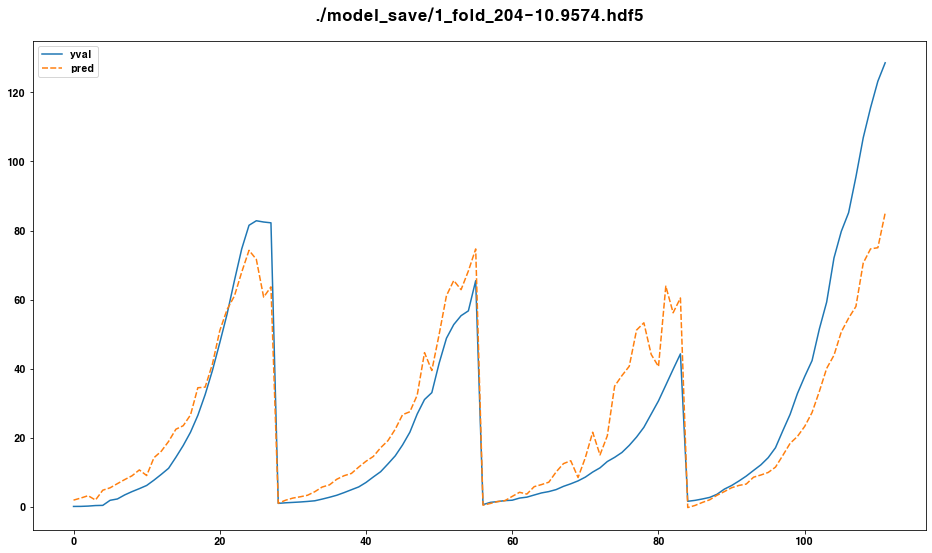

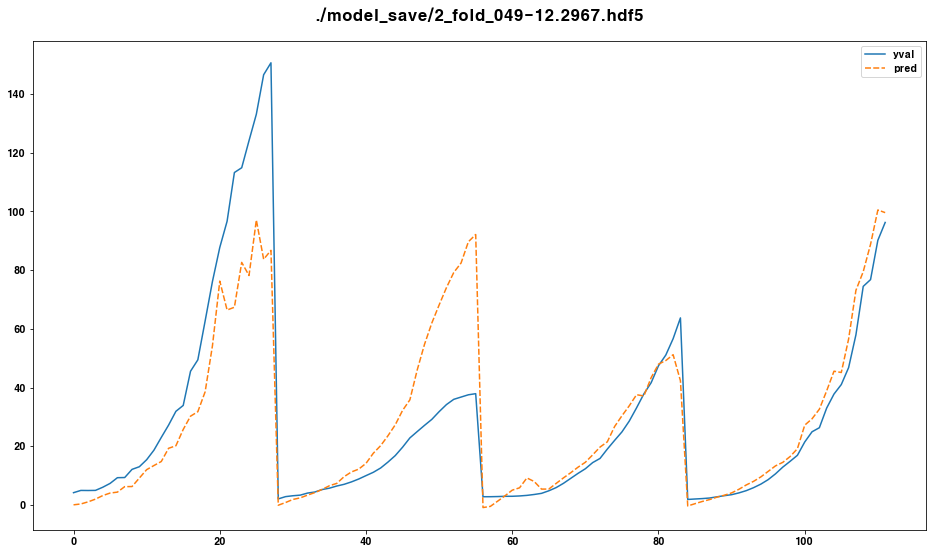

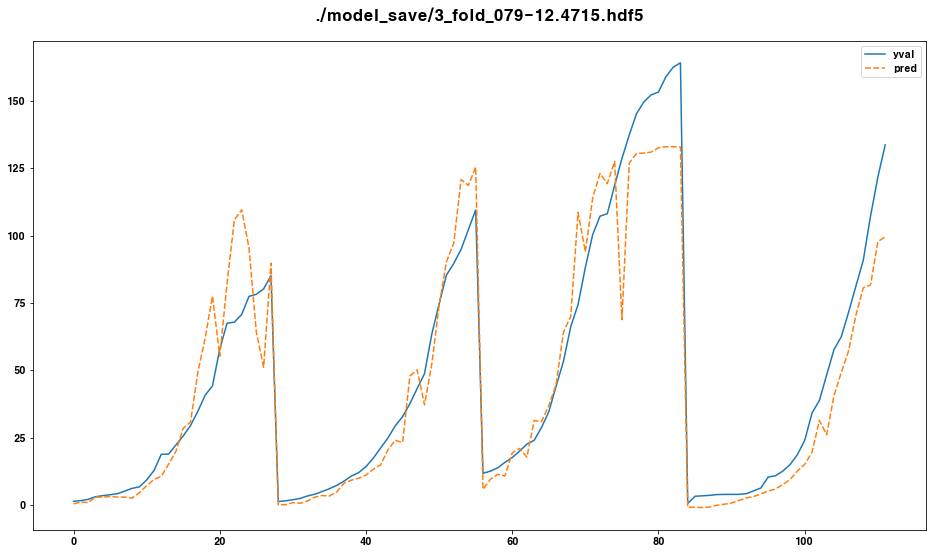

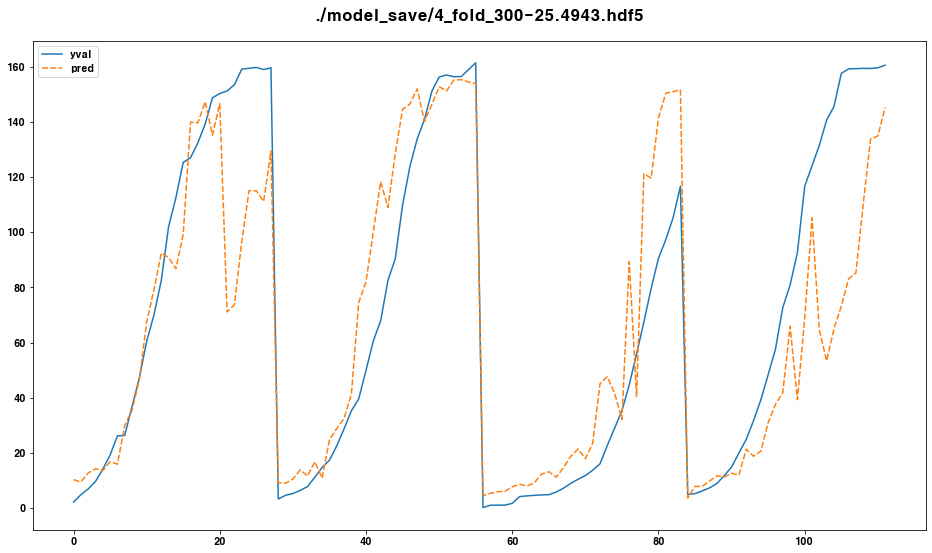

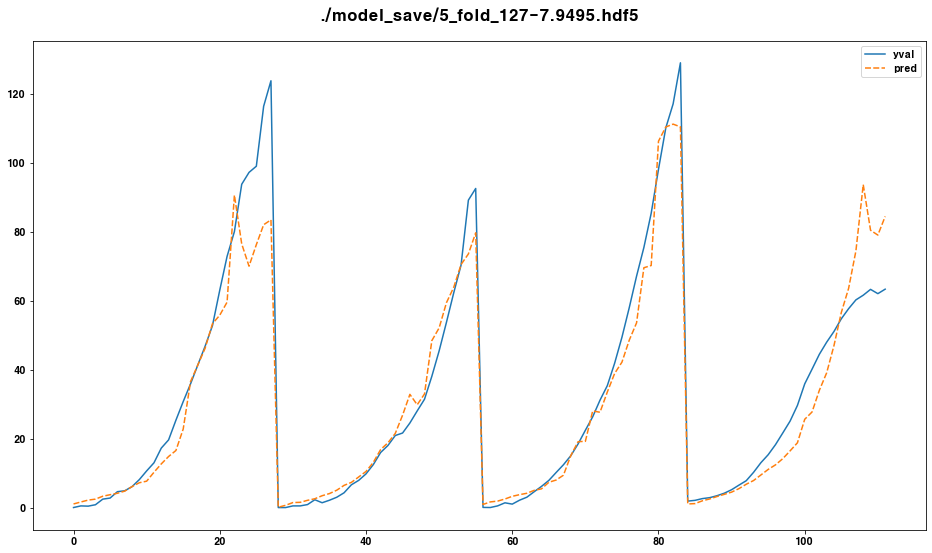

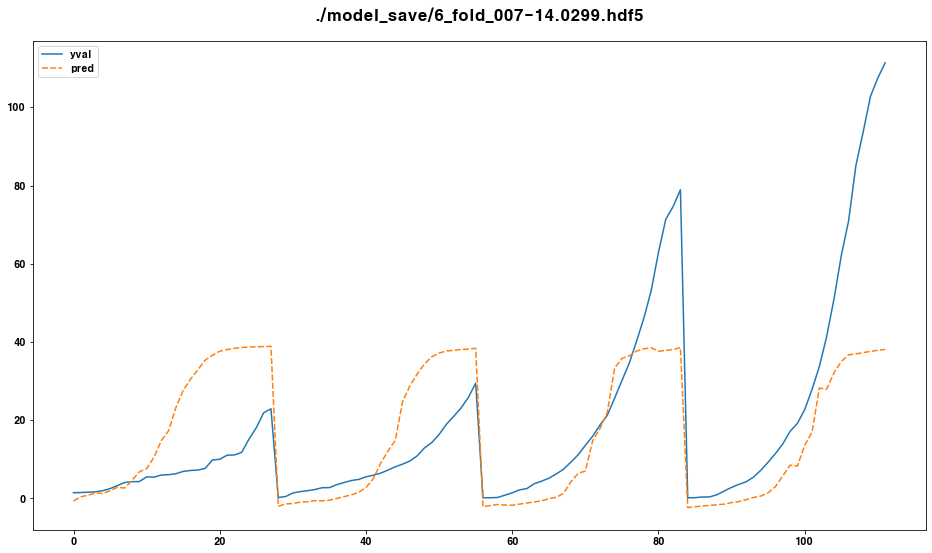

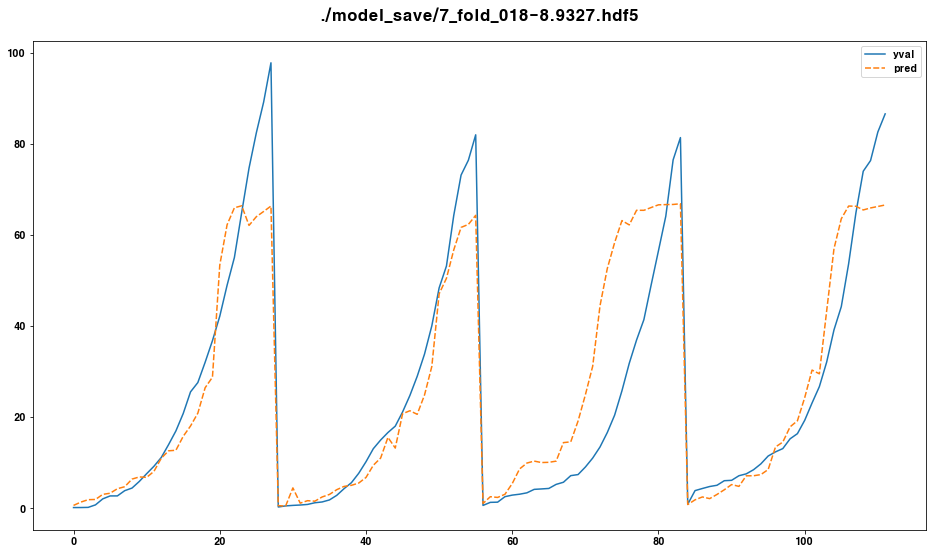

In [68]:
# 7번의 교차 검증으로 학습한 결과중 가장 우수하게 학습된 top3의 모델 선별
# 각 모델들이 어떻게 validation을 진행하였는지 graph 그려보기
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

hdf5_path = './model_save/'

files = os.listdir(hdf5_path)

models_list = []

for file in files:
    if 'hdf5' in file:
        models_list.append(hdf5_path+file)


for i, model in enumerate(models_list):
    print('-'*5, '<', model, '>', '-'*5)
    loaded_model = load_model(model, custom_objects={'rmse': rmse})
    
    pred = loaded_model.predict(X_val_list[i])

    yval_df = pd.DataFrame(y_val_list[i])
    pred_df = pd.DataFrame(pred)

    val_pred_df = pd.DataFrame(pd.concat([yval_df, pred_df], axis=1).values, columns=['yval', 'pred'])
    
    plt.figure(figsize=(16,9))
    plt.rcParams['font.family'] = 'HYGothic-Extra'
    title_font = {'fontsize': 16,
                  'fontweight': 'bold'}
    plt.title(model, fontdict=title_font, pad=20)
    sns.lineplot(data=val_pred_df)

### TEST
* 총 7개의 fold, 그 중에서도 가장 학습이 잘 되어 보이는 모델로 test data 예측 진행

In [69]:
# test data 불러오기
test_path = './test_input/'

files = os.listdir(test_path)

test_df_list = []

for file in files:
    if 'csv' in file:
        df = pd.read_csv(test_path+file)
        test_df_list.append(df)

In [70]:
# test data 전처리 진행(절댓값, 정규화)
test_df = pd.concat(test_df_list).reset_index(drop=True)

test_df1 = prepro(test_df)

In [71]:
## 일간누적
# test_df2 = mm_test_df.iloc[:,[0,2,3,4,5,7,9,11,13,15]]

## 시간당
test_df2 = test_df1.iloc[:,[0,2,3,4,5,6,8,10,12,14]]

## 모두 사용
# test_df2 = mm_test_df.drop(['obs_time'], axis=1)

test_df2

,DAT,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,시간당총광량
0,0.0,0.261725,0.578485,0.197276,0.730669,0.000000,0.000000,0.0,0.0,0.000000
1,0.0,0.273344,0.575470,0.198170,0.731802,0.371075,0.000000,0.0,0.0,0.000000
2,0.0,0.244656,0.572234,0.198677,0.734435,0.000000,0.000000,0.0,0.0,0.000000
3,0.0,0.243811,0.577090,0.204206,0.734663,0.371075,0.000000,0.0,0.0,0.000000
4,0.0,0.266185,0.579299,0.192857,0.735246,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
3355,1.0,0.179533,0.562669,0.154537,0.650580,0.000000,0.000333,0.0,0.0,0.000163
3356,1.0,0.186837,0.547551,0.150698,0.651106,0.039081,0.000000,0.0,0.0,0.000000
3357,1.0,0.162233,0.537753,0.143140,0.651001,0.000000,0.000000,0.0,0.0,0.000000
3358,1.0,0.152314,0.528798,0.133168,0.651873,0.060800,0.000000,0.0,0.0,0.000000


In [72]:
# test feature data를 24시간 간격으로 자르기
sliced_list = slice_24(test_df2)

test_input = np.array(sliced_list)
test_input = test_input.reshape(140,24,10,1)

In [80]:
# validation loss 값이 가장 작았던 모델로 예측 진행..
testPreds = []

for model in models_list[0::2]:
    selected_model = load_model(model, custom_objects={'rmse':rmse})
    print(model)

    testPred = selected_model.predict(test_input)
    testPredDf = pd.DataFrame(testPred, columns=['predicted_weight_g'])
    testPreds.append(testPredDf)

./model_save/1_fold_204-10.9574.hdf5
5/5 [==============================] - 0s 10ms/step
./model_save/3_fold_079-12.4715.hdf5
5/5 [==============================] - 0s 9ms/step
./model_save/5_fold_127-7.9495.hdf5
5/5 [==============================] - 0s 6ms/step
./model_save/7_fold_018-8.9327.hdf5
5/5 [==============================] - 0s 9ms/step


In [96]:
vote_df = pd.concat(testPreds, axis=1)
mean_df = pd.DataFrame(vote_df.iloc[:,:-1].mean(axis='columns'), columns=['predicted_weight_g'])
mean_df.index.name='DAT'
mean_df

,predicted_weight_g
DAT,
0,10.324325
1,14.852734
2,11.876583
3,16.205376
4,20.176702
...,...
135,62.978054
136,98.251160
137,95.945656


<AxesSubplot:xlabel='DAT', ylabel='predicted_weight_g'>

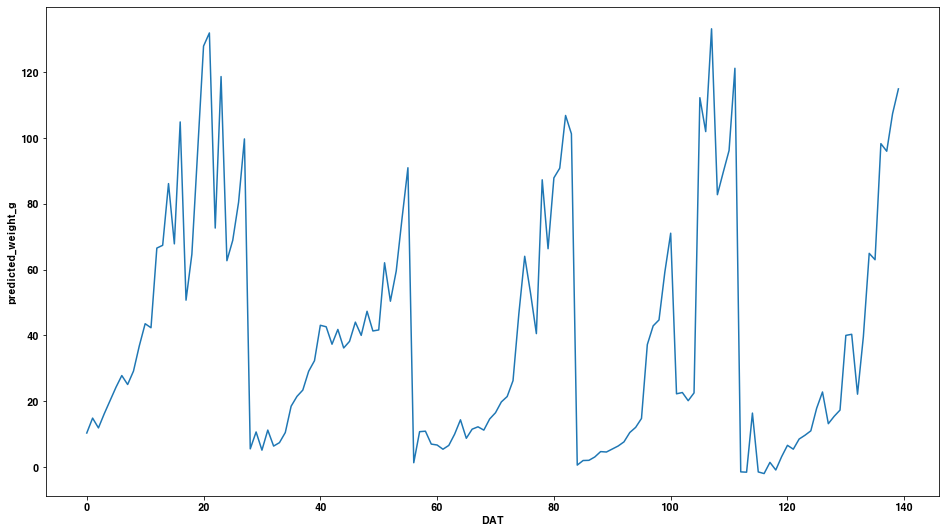

In [97]:
# 예측값 그래프 그리기
plt.figure(figsize=(16,9))
sns.lineplot(data = mean_df, x=mean_df.index, y='predicted_weight_g')

In [98]:
# 최적 모델의 예측 값을 28일 단위로 나누어 list에 append

testResults = []

for i in range(5):
    testResults.append(mean_df.iloc[i*28:(i+1)*28,:].reset_index(drop=True))

In [99]:
# 최적 모델의 예측 값들을 28일 단위로 총 5개의 csv에 저장. (결과)

for i, df in enumerate(testResults):
    df.index += 1
    df.index.name = 'DAT'
    
    df.to_csv(f'./test_target/TEST_0{i+1}.csv', encoding='utf-8')

# <정성평가>

In [71]:
# Shap을 통해 가장 가중치가 높게 작용된 부분을 찾아 해당 부분의 값을 높게 적용하는 생육환경을 추천할 생각..
# Shap으로 이미지파일에서 

# from omnixai.data.image import Image
# from omnixai.explainers.vision import ShapImage

# preprocess_func = lambda x: x
# explainer = ShapImage(model=selected_model, preprocess_function=preprocess_func)

In [ ]:
# select backgroud for shap
background = [np.random.choice(.shape[0], 1000, replace=False)]
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(selected_model, background)
# compute shap values
shap_values = explainer.shap_values(x_test_each_class)